# **📚 ПРОЕКТ A/B-теста размещения рекламного блок**
# Аналитическая записка

### **1. Загрузка библиотек**


In [112]:
# =====================
# ⚙️ Импорт необходимых библиотек
# =====================

# Работа с данными и числами (numpy / pandas — базовые для чисел и таблиц)
import numpy as np               # массивы, векторные расчёты, доли, доверительные интервалы
import pandas as pd              # DataFrame, агрегации и фильтрации

# Визуализация (seaborn / matplotlib — для всех видов графиков: от гистограмм до barplot и кастомных визуализаций)
import seaborn as sns                  # seaborn для sns.barplot, sns.histplot и удобных стилевых настроек
import matplotlib.pyplot as plt        # базовые команды построения графиков
from matplotlib.patches import Patch   # для ручной подготовки легенды на графике
import matplotlib.patches as mpatches  # импорт для прямоугольников

# Текстовые утилиты (textwrap — перенос длинных строк внутри графиков)
import textwrap                  # перенос длинных заголовков или подписей

# Вывод в Jupyter (display - вывод таблиц и стилизованных DataFrame в ноутбуке)
from IPython.display import display  # display() для красивого вывода DataFrame и Styler

# Статистические функции (scipy.stats.norm — для расчётов доверительных интервалов и MDE (нормальное приближение),
# ttest_ind — двухвыборочный t-тест для дополнительных сравнений)
from scipy.stats import norm, ttest_ind      # norm.ppf для z-критических значений; ttest_ind для сравнения групп

# Интерполяция (опционально, для графиков чувствительности MDE) (interp1d — если строим графики зависимости MDE от размера выборки)
from scipy.interpolate import interp1d

# Анализ мощности теста и расчёт sample size (NormalIndPower — для оценки мощности теста и минимального размера группы)
from statsmodels.stats.power import NormalIndPower


### **2. Загрузка цветов проекта**

In [113]:
# =====================
# ⚙️ Цветовые схемы для визуализации
# =====================

# 🟦 Цвета по метрикам
metric_colors = {
    'CTR':                '#4169E1',  # яркий, чистый синий, было: #4C72B0 (тёмно-голубой)
    'CR':                 '#2E8B57',  # сочный, читаемый зелёный, было: #55A868 (зелёный)
    'Conv_view_to_add':   '#C44E52',  # красный
    'Revenue_per_user':   '#8172B2',  # фиолетовый
    'ARPU':               '#FFA07A',  # светло-коралловый
    'ARPPU':              '#FF7F0E',  # оранжевый
    'CR_click_to_order':  '#1F77B4',  # тёмно-синий
    'CR_view_to_order':   '#2CA02C',  # тёмно-зелёный
    'Average_Order_Value':'#8C564B',  # коричневатый
}

# 🔻 Цветовая палитра для воронки (views → clicks → adds)
funnel_colors = [
    '#92D8FD',  # просмотрели (views)
    '#467BBF',  # кликнули (clicks)
    '#314671'   # добавили (adds)
]

# 👥 Цвета групп A/B-теста
"""
group_colors = {
    'control': '#B0DEFA',  # чуть светлее
    'test':    '#6C8BC2',  # адаптированный синий
}
"""
group_colors = {
    'control': '#66CCFF',  # ярко-голубой
    'test':    '#357ABD',  # насыщенный синий
}

experiment_share_colors = [
    '#6FA8DC',  # Насыщенный голубовато-синий — для участников (тест + контроль)
    '#D9D9D9'   # Светло-серый — для остальных (не участвовали)
]

# 📊 Палитра по метрикам (для boxplot по порядку)
default_palette = list(metric_colors.values())

# 🧾 Объекты легенды для ручного построения (например, plt.legend(handles=...))
legend_handles = [
    Patch(facecolor=group_colors['control'], label='Контроль'),
    Patch(facecolor=group_colors['test'], label='Тест')
]


### **3. Загрузка констант проекта (читабельные имена)**

In [114]:
# =====================
# ⚙️ Обновлённый словарь metric_labels (для всех метрик проекта ДО и ЭКСПЕРЕМЕНТ)
# =====================

metric_labels = {
    'CTR':                     'Доля пользователей, увидевших рекламу (CTR)',
    'CR':                      'Доля пользователей, добавивших товар (CR)',
    'Conv_view_to_add':        'Конверсия просмотра → добавление',
    'Revenue_per_user':        'Выручка на пользователя (ARPU)',
    'ARPU':                    'Выручка на пользователя (ARPU)',
    'ARPPU':                   'Выручка на покупателя (ARPPU)',
    'CR_click_to_order':       'Конверсия: клик → заказ',
    'CR_view_to_order':        'Конверсия: просмотр → заказ',
    'Conv_click_to_order':     'Конверсия: клик → заказ',
    'Conv_view_to_order':      'Конверсия: просмотр → заказ',
    'Average_Order_Value':     'Средний чек (AOV)',
    'Avg_order_value':         'Средний чек (AOV)',
    'Orders_per_user':         'Среднее число заказов на пользователя',
    'users':                   'Уникальные пользователи в группе',
    'unique_purchasers':       'Уникальные покупатели (с заказами)',
    'total_orders':            'Общее количество заказов',
    'total_revenue':           'Общая выручка'
}

# =====================
# ⚙️ Названия событий (до эксперимента) + перевод (views, clicks, adds — это основные действия до эксперимента)
# =====================
event_type_labels = {                            # Для визуализации и легенд, вывода в графиках, заголовках
    'views':  'Просмотр главной (views)',
    'clicks': 'Клик по рекламе (clicks)',
    'adds':   'Добавление из рекламы (adds)'
}

# 🎯 Сопоставление флагов с типами событий
event_flag_mapping = {                           # Для автоматического создания флагов в коде, для компактного создания колонок-флагов через for
    'raw_view_flag':  'views',
    'raw_click_flag': 'clicks',
    'raw_add_flag':   'adds'
}

# =====================
# ⚙️ Читабельные названия колонок (эксперимент)
# =====================
col_labels = {
    # 👉 Агрегация на уровне клиента
    'client_id':      'Уникальные пользователи',
    'is_view_ads':    'Дни с показами рекламы',
    'cnt_view_ads':   'Всего показов рекламы',
    'is_adds_ads':    'Дни с добавлениями из рекламы',
    'cnt_adds_ads':   'Всего добавлений в корзину',
    'sum_adds_ads':   'Суммарная стоимость добавенных товаров',
    'is_orders_ads':  'Дни с заказами из рекламы',
    'cnt_orders_ads': 'Всего заказов из рекламы',
    'sum_orders_ads': 'Суммарная выручка из заказов',

    # 👉 Средние значения по пользователям (группы)
    'is_view_ads_mean':    'Доля пользователей с показами рекламы',
    'cnt_view_ads_mean':   'Среднее число показов рекламы',
    'is_adds_ads_mean':    'Доля пользователей, добавивших товар',
    'cnt_adds_ads_mean':   'Среднее число добавлений из рекламы',
    'sum_adds_ads_mean':   'Средняя сумма добавлений из рекламы',
    'is_orders_ads_mean':  'Доля пользователей, оформивших заказ',
    'cnt_orders_ads_mean': 'Среднее число заказов на пользователя',
    'sum_orders_ads_mean': 'Средняя сумма заказов на пользователя',
}


### **4. Параметры А/В - теста**

In [115]:
# =====================
# ⚙️ Параметры A/B-теста (для расчётов мощности, MDE и CI)
# =====================

# 1️⃣ Уровень значимости и мощность теста
ALPHA = 0.05                     # ошибка I рода (по проекту- 0.05), вероятность ложно положительного результата
BETA  = 0.2                      # ошибка II рода (по проекту- 0.2 → мощность 80%), вероятность ложно отрицательного результата

# 2️⃣ Z-квантили стандартного нормального распределения
Z_ALPHA_2 = norm.ppf(1 - ALPHA / 2)  # двухсторонний квантиль (примерно 1.96)
Z_BETA    = norm.ppf(1 - BETA)       # квантиль для мощности (примерно 0.84)

# 3️⃣ Сумма и квадрат суммы Z-критериев (для формул MDE и sample size)
Z_SUM     = Z_ALPHA_2 + Z_BETA       # ≈ 2.8
Z_SUM_SQ  = Z_SUM ** 2               # ≈ 7.84

# 4️⃣ Кол-во групп в тесте (контроль и тест) — по проекту всего 2
N_GROUPS = 2

# 5️⃣ Доля выборки, доступной для эксперимента (тест + контроль)
MAX_SHARE = 0.2   # максимум 20% пользователей участвуют в тесте



### **5.Структура данных и переменных в проекте**

> Для предотвращения путаницы все переменные и датафреймы именуются по шаблону: `prefix_content_period`, где:
> - `prefix`: тип переменной (`df_`, `group_`, `metrics_`, `ci_`, `user_`)
> - `content`: содержимое (`raw`, `results`, `metrics`, `var`, `ci`, `base`)
> - `period`: `raw` (до эксперимента) или `exp` (после эксперимента)

🔹 Основные источники данных:
- `df_raw` — события пользователей ДО эксперимента (`data_raw.csv`)
- `df_results` — данные ПОСЛЕ эксперимента (`final_results_to_analyze.xlsx`)

---
🔹 Данные до эксперимента (`*_raw`):
- `user_metrics` — агрегированные пользовательские метрики до эксперимента
- `group_base_raw` — агрегация метрик по всем пользователям (до теста)
- `metrics_var_raw_df` — расчёт средних, дисперсий, std и размера выборки
- `ci_df_raw` — доверительные интервалы по метрикам (до эксперимента)

---
🔹 Данные после эксперимента (`*_exp`):
- `group_base_exp` — агрегация по группам (контроль и тест)
- `metrics_var_exp_df` — расчёт средних, дисперсий, std (по результатам эксперимента)
- `ci_df_exp` — доверительные интервалы по метрикам (после эксперимента)
- `delta_df` — разности метрик между группами + доверительные интервалы

---

🖼️ Визуализации и подписи
- `metric_labels` — словарь: код метрики → читабельное описание
- `colors` — словарь цветов для метрик на графиках


| Название переменной | Назначение                     | Префикс    | Пример имени                                    |
| ------------------- | ------------------------------ | ---------- | ----------------------------------------------- |
| `*_raw`             | Сырые данные (до эксперимента) | `raw_`     | `raw_user_df`                                   |
| `*_metrics`         | Метрики по пользователям       | `user_`    | `user_metrics`                                  |
| `*_agg`             | Агрегация по группам           | `group_`   | `group_base_raw` (до), `group_base_exp` (после) |
| `*_var_df`          | Таблица дисперсий и MDE        | `metrics_` | `metrics_var_raw_df`, `metrics_var_exp_df`      |
| `*_ci_df`           | CI по метрикам                 | `ci_`      | `ci_df_raw`, `ci_df_exp`                        |
| `*_df`              | Общие датафреймы               | `df_`      | `df_raw`, `df_results`                          |
| `*_plot`            | Для графиков                   | `plot_`    | `plot_mde_sensitivity`                          |


### **6.Используемые функции в проекте**

- `var_ratio(x, y)` — расчёт дисперсии ratio-метрики по дельта-методу. Подробнее: блок 41.
- `get_MDE(mu, std, sample_size, ...)` — расчёт минимального различимого эффекта. Подробнее: блок 42.


# **🔹 ЧАСТЬ 1: ДИЗАЙН ЭКСПЕРИМЕНТА И РАСЧЕТ МИНИМАЛЬНОГО ЭФЕКТА (MDE)**

# **1. Введение и постановка задачи**

#### **1.1. Цель, гипотеза и ограничения эксперимента**

**Задача:**
Проверить влияние изменения расположения рекламного блока: в тестовой группе реклама будет размещена **над основной секцией**.

**Цель:**
Оценить, влияет ли новое расположение на вовлечённость пользователей и поведение в приложении.

**Гипотеза:**
Размещение рекламы выше товарной секции **положительно влияет** на ключевые метрики:

* **CTR** — кликабельность секции рекламы
* **CR** — конверсия в добавление товаров из рекламы

**Критерий успеха:**
Если ключевая метрика (**CR**) статистически значимо увеличится, тест считается успешным.

**Ограничения:**

* Период проведения: 1 неделя (аналогично предыдущему тесту).
* В прошлый раз было зафиксировано увеличение CR на **2.5%**.
* Выбор такого же срока обусловлен планируемыми изменениями в каталоге.

---


### **1.2. Выбор ключевой и вспомогательных метрик**

**Анализируемые метрики:**

| Метрика                    | Формула                  | Назначение                         |
| -------------------------- | ------------------------ | ---------------------------------- |
| **CTR**                    | `clicks / views`         | Кликабельность секции рекламы      |
| **CR**                     | `adds / clicks`          | Конверсия в добавление после клика |
| **Conv\_view\_to\_add**    | `adds / views`           | Конверсия добавлений от просмотров |
| **Conv\_click\_to\_order** | `orders / clicks`        | Конверсия в заказ после клика      |
| **Conv\_view\_to\_order**  | `orders / views`         | Конверсия в заказ от просмотра     |
| **ARPU**                   | `revenue / all users`    | Выручка на пользователя            |
| **ARPPU**                  | `revenue / paying users` | Выручка на покупателя              |

---

**Обоснование выбора ключевой метрики:**

* Метрика **CR** (`adds / clicks`) отражает ключевое целевое действие — добавление товара после взаимодействия с рекламой.
* Она **ближе к бизнес-цели**, чем просто клики.
* В предыдущем эксперименте **реальный рост** наблюдался именно по этой метрике.
* CR зависит от поведения **внутри секции**, а не просто от вовлечения (в отличие от CTR).

---

**Вывод:**

* 🔑 **Ключевая метрика:** **CR** — конверсия в добавление (`adds / clicks`)
* 📎 **Дополнительные метрики:**

  * **CTR** — кликабельность рекламы (`clicks / views`)
  * **Conv\_view\_to\_add** — конверсия добавлений от просмотра (`adds / views`)

---


# **2. Подготовка и первичная обработка данных**

### **2.1. Загрузка сырых данных (data_raw.csv) и первичный анализ**

---
**Данные** до эксперемента: data_raw.csv

**Цель**: Посмотреть структуру и содержимое.

In [116]:
# ⚙️ Загрузка сырых данных (data_raw.csv)

# 1️⃣ Чтение CSV-файла с сырыми событиями пользователей до эксперимента
df_raw = pd.read_csv(
    '/content/drive/MyDrive/ПОРТФОЛИО/портфолио в Python/AB_test/Источники/data_raw.csv'
)
# 2️⃣ Преобразуем колонку даты в datetime (ошибки → NaT)
df_raw['dt'] = pd.to_datetime(df_raw['dt'], errors='coerce')

# Нормализуем dt до даты (отбрасываем время)
#df_raw['dt_date'] = pd.to_datetime(df_raw['dt']).dt.normalize()


# 3️⃣ Первичный обзор структуры и качества данных
print("\n📋 Колонки в df_raw:\n")
print(df_raw.columns.tolist())                   # выводим список всех колонок
print("\n📋 структура таблицы и пропуски:")
print(df_raw.info())                             # структура таблицы и пропуски
print("\n📦 Типы данных по колонкам:")
print(df_raw.dtypes)                             # тип данных в каждой колонке
print("\n🔍 Пропуски в каждой колонке:")
print(df_raw.isna().sum())                       # число NaN в каждой колонке
print("\n👤 Число уникальных пользователей:")
print(df_raw['client_id'].nunique())             # подсчет уникальных client_id
print("\n🧾 Распределение событий по типу:")
print(df_raw['event_type'].value_counts())       # сколько views, clicks, adds
print("\n🧾 Проверка - нормализована ли дата:\n Если результат = 1, и это 00:00:00 → ✅ даты нормализованы. \n Если >1 → значит, в колонке dt остались значения с временем и требуется нормализация")
print(df_raw['dt'].dt.time.nunique())



📋 Колонки в df_raw:

['Unnamed: 0', 'client_id', 'dt', 'event_type']

📋 структура таблицы и пропуски:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  int64         
 1   client_id   int64         
 2   dt          datetime64[ns]
 3   event_type  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 847.0+ MB
None

📦 Типы данных по колонкам:
Unnamed: 0             int64
client_id              int64
dt            datetime64[ns]
event_type            object
dtype: object

🔍 Пропуски в каждой колонке:
Unnamed: 0    0
client_id     0
dt            0
event_type    0
dtype: int64

👤 Число уникальных пользователей:
3102736

🧾 Распределение событий по типу:
event_type
views     27006473
clicks      535927
adds        213648
Name: count, dtype: int64

🧾 Проверка - нормализована ли дата:
 Если результат = 1, и это 00:00:00 → ✅ да

## **2.2. Приведение к формату «воронки»**

Для анализа пользовательского поведения данные агрегируются по `client_id` и `dt` с преобразованием в бинарный формат. Это позволяет отразить факт события, произошедшего хотя бы один раз за день.

**Логика интерпретации бинарных флагов:**

* `views = 1` — пользователь хотя бы раз зашёл в приложение в этот день;
* `clicks = 1` — был хотя бы один клик по рекламе;
* `adds = 1` — пользователь добавил товар из рекламы в корзину.

---

#### **2.2.1. Создание бинарных флагов событий**

Для корректного анализа события выделяются в отдельные флаги:

| Флаг         | Условие                            |
| ------------ | ---------------------------------- |
| `view_flag`  | `1`, если `event_type == 'views'`  |
| `click_flag` | `1`, если `event_type == 'clicks'` |
| `add_flag`   | `1`, если `event_type == 'adds'`   |
| —            | `0` во всех остальных случаях      |

Затем данные агрегируются по пользователю и дате с помощью `max()`, чтобы учесть факт хотя бы одного события за день.

---

In [117]:
# =====================
# 📦 БЛОК 2.2.1: Создание бинарных флагов событий (нулевой период)
# =====================

# Используем event_flag_mapping из констант для автоматического создания 0/1 флагов
# Каждому новому столбцу (например raw_view_flag) соответствует определённый тип события ('views')
for flag_col, event_type in event_flag_mapping.items():
    df_raw[flag_col] = (df_raw['event_type'] == event_type).astype(int)

# 📌 Формируем отдельный датафрейм raw_df с нужными колонками:
# дата, пользователь и бинарные флаги событий
raw_df = df_raw[['client_id', 'dt',
                 'raw_view_flag', 'raw_click_flag', 'raw_add_flag']].copy()

# Проверим результат
print("✅ Таблица бинарных флагов событий (нулевой период):")
display(raw_df.head())


✅ Таблица бинарных флагов событий (нулевой период):


,client_id,dt,raw_view_flag,raw_click_flag,raw_add_flag
0,6095092,2024-06-20,0,1,0
1,541138559,2024-06-18,0,1,0
2,12189072,2024-06-20,0,1,0
3,674385020,2024-06-20,0,1,0
4,726939378,2024-06-20,0,1,0


#### **2.2.2. Визуализация воронки событий**

Для построения воронки пользовательских действий агрегируем данные по `client_id`, суммируя флаги `view_flag`, `click_flag`, `add_flag` за весь период.

Затем переводим значения в бинарный формат и считаем действия пользователей:

* сколько пользователей видели главную страницу (views),
* сколько кликали по рекламе (clicks),
* сколько добавляли товары из рекламы (adds).

На основе этих данных строится воронка поведения, отражающая конверсию на каждом этапе взаимодействия с рекламой.

---

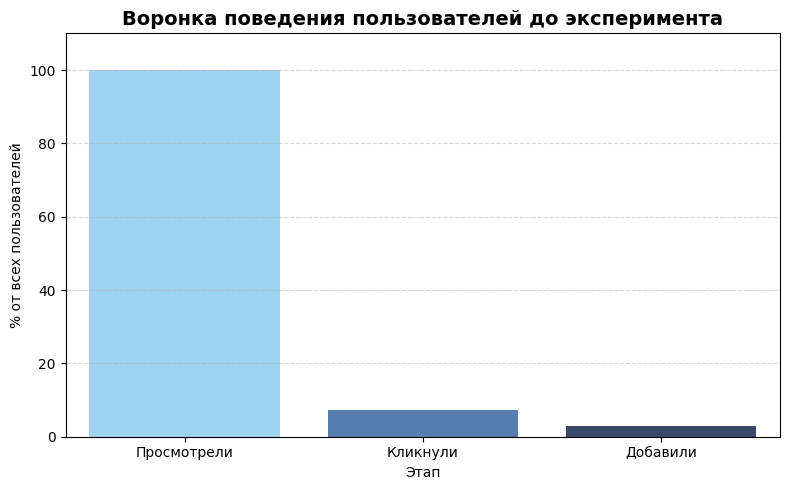

📊 Воронка поведения пользователей (до эксперимента):


,Этап,% пользователей
0,Просмотрели,100.00
1,Кликнули,7.36
2,Добавили,2.91


In [118]:
# =====================
# 📦 БЛОК 2.2.2: Построение воронки событий (до эксперимента)
# =====================

# 1️⃣ Агрегируем поведение по пользователям:
# сколько дней каждый пользователь совершал нужные действия
funnel_df = raw_df.groupby('client_id')[
    ['raw_view_flag', 'raw_click_flag', 'raw_add_flag']
].sum()

# 2️⃣ Переводим в бинарный формат:
# если пользователь хотя бы один день совершал действие — фиксируем как 1
funnel_df = (funnel_df > 0).astype(int)

# 3️⃣ Подсчитываем количество пользователей на каждом этапе воронки
total_users = funnel_df.shape[0]
n_viewed    = funnel_df['raw_view_flag'].sum()
n_clicked   = funnel_df['raw_click_flag'].sum()
n_added     = funnel_df['raw_add_flag'].sum()

# 4️⃣ Рассчитываем % от общей базы
funnel_percent = {
    'Просмотрели': round(n_viewed  / total_users * 100, 2),
    'Кликнули':    round(n_clicked / total_users * 100, 2),
    'Добавили':    round(n_added   / total_users * 100, 2)
}

# 5️⃣ Собираем итоговую таблицу для вывода и графика
funnel_summary = (
    pd.DataFrame.from_dict(funnel_percent, orient='index', columns=['% пользователей'])
    .reset_index()
    .rename(columns={'index': 'Этап'})
)

# 6️⃣ Визуализируем barplot — воронку поведения
plt.figure(figsize=(8, 5))
sns.barplot(
    data=funnel_summary,
    x='Этап',
    y='% пользователей',
    hue='Этап',
    palette=funnel_colors,  # палитра из констант
    dodge=False,
    legend=False
)

# 7️⃣ Настройка графика
plt.title('Воронка поведения пользователей до эксперимента', fontsize=14, weight='bold')
plt.ylabel('% от всех пользователей')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 8️⃣ Отображаем таблицу с результатами
print("📊 Воронка поведения пользователей (до эксперимента):")
display(funnel_summary)


## **2.3. Агрегация пользовательских данных (`user_metrics`)**

**Цель:** подготовить агрегированные пользовательские данные до эксперимента для расчёта ключевых метрик и дальнейшего анализа.

---

**Расчёт пользовательских метрик**
На основе итогов по каждому пользователю рассчитываем ключевые ratio-метрики:

* **CTR** = `clicks / views` — кликабельность рекламного блока;
* **CR** = `adds / clicks` — конверсия из клика в добавление в корзину;
* **Conv\_view\_to\_add** = `adds / views` — полная конверсия из просмотра в добавление в корзину.

Эти метрики отражают пользовательское поведение и будут использоваться для расчёта дисперсий, доверительных интервалов и чувствительности A/B-теста.

### **2.3.1 Агрегация данных на уровне "пользователь–дата"**

**Цель:** получить бинарные индикаторы активности пользователя в каждый день

Счетчики событий - `views`, `clicks`, `adds`

Агрегируем полученные данные по каждому пользователю (без дат) - файл **`agg_df`**

In [119]:
# =====================
# 📦 БЛОК 2.3.1: Агрегация на уровне «дата–пользователь» (нулевой период)
# =====================

# 1️⃣ Используем raw_df — он содержит только нужные флаги и нормализованную дату
raw_agg_df = (
    raw_df
    .groupby(['dt', 'client_id'], as_index=False)
    .agg(
        views  = ('raw_view_flag',  'max'),
        clicks = ('raw_click_flag', 'max'),
        adds   = ('raw_add_flag',   'max')
    )
)

# 2️⃣ Проверка результата
print("✅ Пример raw_agg_df (агрегация по дате и пользователю):")
display(raw_agg_df.head())


✅ Пример raw_agg_df (агрегация по дате и пользователю):


,dt,client_id,views,clicks,adds
0,2024-06-17,1,1,0,0
1,2024-06-17,3,1,1,0
2,2024-06-17,19,1,0,0
3,2024-06-17,37,1,0,0
4,2024-06-17,41,1,0,0


### **2.3.2 Агрегация на уровне "пользователь"**

Счетчики событий - `views`, `clicks`, `adds`

Агрегируем полученные данные по каждому пользователю (без дат) - файл **`user_counts`**

In [120]:
# =====================
# 📦 БЛОК 2.3.2: Агрегация по пользователю (нулевой период)
# =====================

# 1️⃣ Суммируем флаги по всем датам — сколько дней пользователь совершал то или иное действие
total_user_counts_raw = (
    raw_agg_df
    .groupby('client_id', as_index=False)
    .agg(
        views_count  = ('views',  'sum'),
        clicks_count = ('clicks', 'sum'),
        adds_count   = ('adds',   'sum')
    )
)

# 2️⃣ Добавляем неактивных пользователей (которые вообще не взаимодействовали)
# Это важно, чтобы не искажать расчёт средних и дисперсий по метрикам
all_users_raw = df_raw[['client_id']].drop_duplicates()

user_counts_raw = (
    all_users_raw
    .merge(total_user_counts_raw, on='client_id', how='left')  # добавляем агрегации
    .fillna(0)  # если пользователь ничего не делал → считаем 0
)

# 3️⃣ Приводим типы к целым числам
user_counts_raw[['views_count', 'clicks_count', 'adds_count']] = \
    user_counts_raw[['views_count', 'clicks_count', 'adds_count']].astype(int)

# 4️⃣ Показываем первые строки, чтобы убедиться, что user_counts_raw определён верно
print("✅ user_counts_raw — агрегированные действия пользователей (нулевой период):")
display(user_counts_raw.head())


✅ user_counts_raw — агрегированные действия пользователей (нулевой период):


,client_id,views_count,clicks_count,adds_count
0,6095092,4,3,0
1,541138559,3,3,0
2,12189072,4,3,0
3,674385020,3,2,0
4,726939378,4,2,0


### **2.3.3 Расчет пользовательских ratio-метрик:** **CTR**, **CR** и **Conv_view_to_add**.

**Проверка реализуемости расчёта метрик (по заданию проекта) на исторических данных (0 период)**

| Метрика                            | Формула                | Назначение                              | Можно рассчитать? | Комментарий                                         |
| ---------------------------------- | ---------------------- | --------------------------------------- | ----------------- | --------------------------------------------------- |
| **CTR**                            | clicks / views         | Кликабельность рекламного блока         | ✅                 | Все данные есть / Дополнительная метрика                                    |
| **CR**                             | adds / clicks          | Конверсия в добавление товаров          | ✅                 | КЛЮЧЕВАЯ МЕТРИКА                                    |
| **Conv\_view\_to\_add**            | adds / views           | Альтернатива CR: конверсия от просмотра | ✅                 | Дополнительная метрика                              |
| **Конверсия в заказ от клика**     | orders / clicks        | Эффективность переходов в заказы        | ❌                 | Отсутствуют данные о заказах (нет столбца `orders`) |
| **Конверсия в заказ от просмотра** | orders / views         | Эффективность просмотров                | ❌                 | Нет событий заказов                                 |
| **ARPU**                           | revenue / all users    | Выручка на пользователя                 | ❌                 | Нет данных о суммах заказов                         |
| **ARPPU**                          | revenue / paying users | Выручка на покупателя                   | ❌                 | Отсутствует информация о платящих пользователях     |

In [121]:
# =====================
# 📦 БЛОК 2.3.3/1: Расчёт пользовательских ratio-метрик (нулевой период)
# =====================

# 📌 Используем user_counts_raw (агрегированные данные по пользователям)
user_metrics_raw = user_counts_raw.copy()

# 1️⃣ Расчёт CTR: отношение кликов к просмотрам
user_metrics_raw['CTR'] = user_metrics_raw['clicks_count'] / \
                          user_metrics_raw['views_count'].replace(0, np.nan)

# 2️⃣ Расчёт CR: отношение добавлений к кликам
user_metrics_raw['CR'] = user_metrics_raw['adds_count'] / \
                         user_metrics_raw['clicks_count'].replace(0, np.nan)

# 3️⃣ Расчёт конверсии из просмотра в добавление
user_metrics_raw['Conv_view_to_add'] = user_metrics_raw['adds_count'] / \
                                       user_metrics_raw['views_count'].replace(0, np.nan)

# 4️⃣ Заменяем NaN на 0 (например, если пользователь не видел рекламу или не кликал)
user_metrics_raw.fillna(0, inplace=True)

# 5️⃣ Проверка результата
print("✅ user_metrics_raw — пользовательские ratio-метрики (нулевой период):")
display(user_metrics_raw.head())


✅ user_metrics_raw — пользовательские ratio-метрики (нулевой период):


,client_id,views_count,clicks_count,adds_count,CTR,CR,Conv_view_to_add
0,6095092,4,3,0,0.750000,0.0,0.0
1,541138559,3,3,0,1.000000,0.0,0.0
2,12189072,4,3,0,0.750000,0.0,0.0
3,674385020,3,2,0,0.666667,0.0,0.0
4,726939378,4,2,0,0.500000,0.0,0.0


In [122]:
# =====================
# 📦 БЛОК 2.3.3/2: Проверка полноты и активности пользователей (нулевой период)
# =====================

# 1️⃣ Проверяем, что все пользователи из исходных данных попали в user_metrics_raw
n_users_raw     = df_raw['client_id'].nunique()
n_users_metrics = user_metrics_raw['client_id'].nunique()

print(f"Всего уникальных пользователей в df_raw:           {n_users_raw:,}")
print(f"Всего в user_metrics_raw (после агрегации и расчётов): {n_users_metrics:,}")

if n_users_raw == n_users_metrics:
    print("✅ Все пользователи учтены.")
else:
    print("⚠️ Есть расхождение в количестве пользователей!")

# 2️⃣ Анализ активности пользователей
total_users = user_metrics_raw.shape[0]

zero_action_users = user_metrics_raw[
    (user_metrics_raw['views_count'] == 0) &
    (user_metrics_raw['clicks_count'] == 0) &
    (user_metrics_raw['adds_count'] == 0)
].shape[0]

view_users = user_metrics_raw[user_metrics_raw['views_count'] > 0].shape[0]
click_users = user_metrics_raw[user_metrics_raw['clicks_count'] > 0].shape[0]
add_users = user_metrics_raw[user_metrics_raw['adds_count'] > 0].shape[0]

# 🔍 Вывод
print(f"\n📊 Активность пользователей:")
print(f"Пользователей всего:                      {total_users:,}")
print(f"— без каких-либо действий:                {zero_action_users:,} ({zero_action_users / total_users:.1%})")
print(f"— с хотя бы одним просмотром:             {view_users:,} ({view_users / total_users:.1%})")
print(f"— с хотя бы одним кликом:                 {click_users:,} ({click_users / total_users:.1%})")
print(f"— с хотя бы одним добавлением в корзину:  {add_users:,} ({add_users / total_users:.1%})")


Всего уникальных пользователей в df_raw:           3,102,736
Всего в user_metrics_raw (после агрегации и расчётов): 3,102,736
✅ Все пользователи учтены.

📊 Активность пользователей:
Пользователей всего:                      3,102,736
— без каких-либо действий:                0 (0.0%)
— с хотя бы одним просмотром:             3,102,735 (100.0%)
— с хотя бы одним кликом:                 228,491 (7.4%)
— с хотя бы одним добавлением в корзину:  90,438 (2.9%)


#### 🔍 Вывод пригодности данных 0 периода:

Данные содержат пользовательские действия до эксперимента, они пригодны для анализа.

На основе исторических данных до запуска A/B-теста сформирована таблица **`user_metrics`**, содержащая ключевые параметры пользовательского поведения:
- количество просмотров (**views**),
- кликов по рекламе (**clicks**),
- добавлений в корзину (**adds**),

| Источник                                              | Что мы знаем                                                                                   |
| ------------------------------------------------- | ---------------------------------------------------------------------------------------------- |
| `df_raw['client_id'].nunique()`                   | **3 102 736** — все пользователи, включая неактивных                                           |
| `user_metrics.shape[0]`                           | тоже **3 102 736** — та же цифра, значит при агрегации и `left join` не «потеряли» ни одного клиента |
| `user_metrics[user_metrics['adds'] > 0].shape[0]` | **90 438** — ≈ 2.9% пользователей совершали добавления     

**Результат:**

Рассчитанны метрики:
- **CTR**,
- **CR**,
- **Conv_view_to_add**.

Получена таблица **`user_metrics`** с одной строкой на пользователя, содержащая информацию о его действиях до эксперимента и рассчитанные метрики. Эти данные лягут в основу сравнения с результатами после эксперимента.

# **3. Оценка разброса метрик (дисперсия) и анализ распределения**

## **3.1. Обоснование использования дельта-метода для ratio-метрик**

**Цель:** Понять распределения ключевых метрик на уровне пользователей до эксперимента:

Есть ли выбросы?

Какой характер распределения (нормальное, асимметричное, с пиками)?

Насколько сильно варьируются значения между пользователями?

Построим графики распределения Гистограммы и boxplot для:

- CTR
- CR
- Conv_view_to_add

### **3.1.1. Визуализация сегмента пользователей в эксперементе**

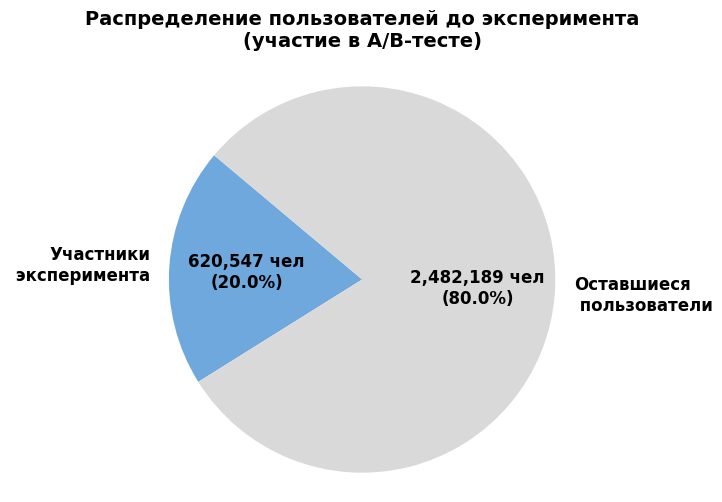

Всего уникальных пользователей до эксперимента: 3,102,736
Максимальное число участников теста и контроля (20%): 620,547


In [123]:
# =====================
# 📦 БЛОК 3.1.1: Визуализация охвата пользователей в A/B-тесте (нулевой период)
# =====================

# 📌 Используем user_metrics_raw — содержит всех уникальных пользователей
total_users = user_metrics_raw['client_id'].nunique()

# 📌 Используем глобальную константу MAX_SHARE (по проекту, 0.2 = 20%)
sample_size_total = int(total_users * MAX_SHARE)
rest_users = total_users - sample_size_total

# 1️⃣ Данные для круговой диаграммы
sizes  = [sample_size_total, rest_users]
labels = ['Участники\n эксперимента', 'Оставшиеся\n пользователи']
colors = [group_colors['test'], group_colors['control']]

# 2️⃣ Функция автоподписей: количество + %
def make_autopct(values):
    def my_autopct(pct):
        absolute = int(round(pct / 100. * sum(values)))
        return f'{absolute:,} чел\n({pct:.1f}%)'
    return my_autopct

# 3️⃣ Построение круговой диаграммы
fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=140,
    colors = experiment_share_colors,

    #colors=colors,  # цвета групп определены в константах
    #colors = [group_colors['test'], group_colors['control']], # цвета групп определены в константах
    textprops=dict(color="black", fontsize=12, weight='bold'),
    radius=1
)

# 4️⃣ Заголовок + форматирование
plt.title(
    'Распределение пользователей до эксперимента\n(участие в A/B-тесте)',
    fontsize=14,
    weight='bold',
    pad=15
)
ax.axis('equal')
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)

# 5️⃣ Показ графика
plt.show()

# 6️⃣ Вывод чисел в консоль
print(f"Всего уникальных пользователей до эксперимента: {total_users:,}")
print(f"Максимальное число участников теста и контроля ({int(MAX_SHARE*100)}%): {sample_size_total:,}")


### **3.1.2. Гистограммы распределений по метрикам**

Распределения метрик **CTR**, **CR** и **Conv\_view\_to\_add** в маркетплейсе ожидаемо скошены:
большинство пользователей не взаимодействуют с рекламой активно, и основная масса значений сосредоточена около нуля.

Это типично для пользовательского поведения:

* только небольшая доля пользователей кликает по рекламе;
* ещё меньшая — добавляет товары из неё.

Такая форма распределений подтверждает необходимость использования дельта-метода при расчётах доверительных интервалов и MDE.

---


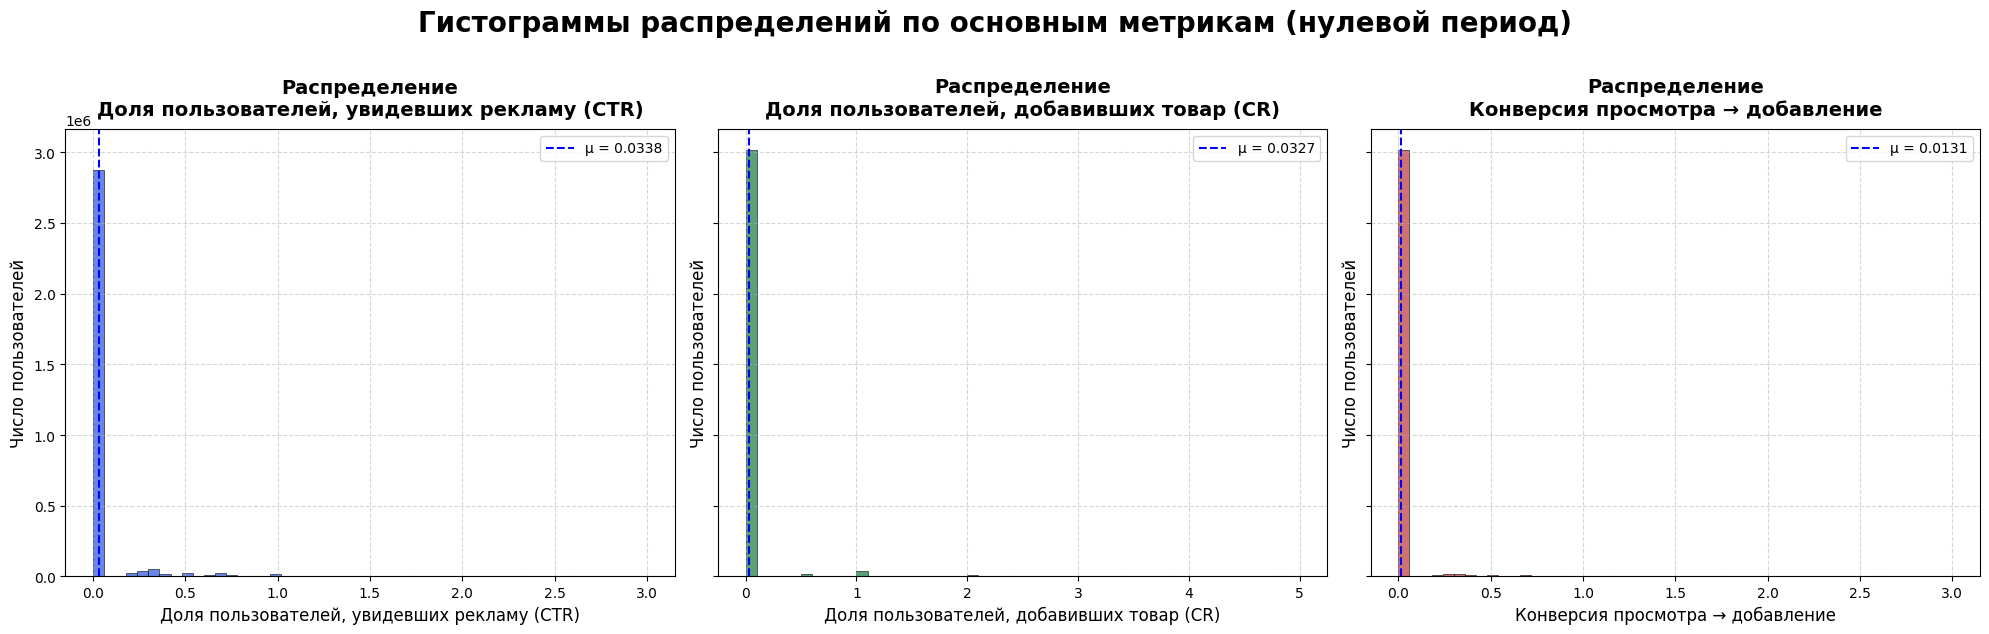

In [124]:
# =====================
# 📦 БЛОК 3.1.2: Гистограммы распределений пользовательских метрик (нулевой период)
# =====================

# 📌 Используем user_metrics_raw — содержит расчётные CTR, CR и Conv_view_to_add
metrics = ['CTR', 'CR', 'Conv_view_to_add']

# 📌 Цвета из глобального словаря metric_colors
colors = [metric_colors[m] for m in metrics]

# 1️⃣ Создаём фигуру с 3 subplot'ами
fig, axes = plt.subplots(
    1, len(metrics),
    figsize=(20, 6),
    sharey=True
)

for ax, metric, color in zip(axes, metrics, colors):
    data = user_metrics_raw[metric].dropna()

    ax.hist(
        data,
        bins=50,
        color=color,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.8
    )

    # Среднее значение
    m = data.mean()
    ax.axvline(
        m,
        color='blue',
        linestyle='--',
        label=f'μ = {m:.4f}'
    )

    # Подписи
    title = metric_labels.get(metric, metric)
    ax.set_title(f'Распределение\n{title}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel('Число пользователей', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10)

# Общий заголовок
fig.suptitle(
    'Гистограммы распределений по основным метрикам (нулевой период)',
    fontsize=20,
    fontweight='bold',
    y=1.05
)

# Отступы
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


### 3.1.3. **Описательная статистика по пользовательским метрикам до эксперимента**

**Цель:**
* Проверить статистические свойства CTR, CR, Conv_view_to_add;
* Получить основные числовые характеристики (mean, std, min, 25%, 50%, 75%, max);
* Узнать моды — самые частые значения (важно при пиковой структуре, как в CR и CTR).

In [125]:
# =====================
# 📦 БЛОК 22: Описательные статистики по основным метрикам (нулевой период)
# =====================

# 1️⃣ Ключевые пользовательские метрики
metrics = ['CTR', 'CR', 'Conv_view_to_add']

# 2️⃣ Рассчитываем описательные статистики
desc = user_metrics_raw[metrics].describe().T  # транспонируем для удобства

# 3️⃣ Заменяем коды метрик на читаемые подписи
desc.index = [metric_labels.get(m, m) for m in desc.index]

# 4️⃣ Вывод таблицы
print("📊 ОСНОВНЫЕ МЕТРИКИ (описательные статистики):")
display(desc)

# 5️⃣ Поиск мод (наиболее частых значений)
print("\n📌 МОДЫ (наиболее частые значения) по метрикам:")
for m in metrics:
    mode_val = user_metrics_raw[m].mode().iloc[0]
    label = metric_labels.get(m, m)
    print(f"— {label}: {mode_val:.4f}")


📊 ОСНОВНЫЕ МЕТРИКИ (описательные статистики):


,count,mean,std,min,25%,50%,75%,max
"Доля пользователей, увидевших рекламу (CTR)",3102736.0,0.033769,0.136911,0.0,0.0,0.0,0.0,3.0
"Доля пользователей, добавивших товар (CR)",3102736.0,0.032719,0.218596,0.0,0.0,0.0,0.0,5.0
Конверсия просмотра → добавление,3102736.0,0.013081,0.086020,0.0,0.0,0.0,0.0,3.0



📌 МОДЫ (наиболее частые значения) по метрикам:
— Доля пользователей, увидевших рекламу (CTR): 0.0000
— Доля пользователей, добавивших товар (CR): 0.0000
— Конверсия просмотра → добавление: 0.0000


In [126]:
# ПРОВЕРКА
display(user_metrics_raw.describe())


,client_id,views_count,clicks_count,adds_count,CTR,CR,Conv_view_to_add
count,3.102736e+06,3.102736e+06,3.102736e+06,3.102736e+06,3.102736e+06,3.102736e+06,3.102736e+06
mean,4.134548e+08,2.664453e+00,1.192622e-01,4.792544e-02,3.376906e-02,3.271936e-02,1.308055e-02
std,3.731770e+08,1.202989e+00,4.770180e-01,3.075107e-01,1.369107e-01,2.185958e-01,8.601976e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.144713e+07,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.425264e+08,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.974171e+08,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.579583e+08,5.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,5.000000e+00,3.000000e+00


**Интерпретация:**

- Медиана и мода = 0.0: более половины пользователей вообще не взаимодействуют (не кликают, не добавляют).

- std >> mean: распределение очень скошенное.

- Максимумы 3–5: означает, что некоторые пользователи совершают много кликов или добавлений на мало просмотров — это шум или гиперактивные клиенты.

### **3.1.4. Boxplot только по активным пользователям (> 0)**

Поскольку более 75% пользователей не взаимодействуют с рекламой (все метрики = 0), распределения визуализированы только по активным пользователям (значения метрик > 0). Это позволяет увидеть форму распределения без искажения за счёт неактивной аудитории.

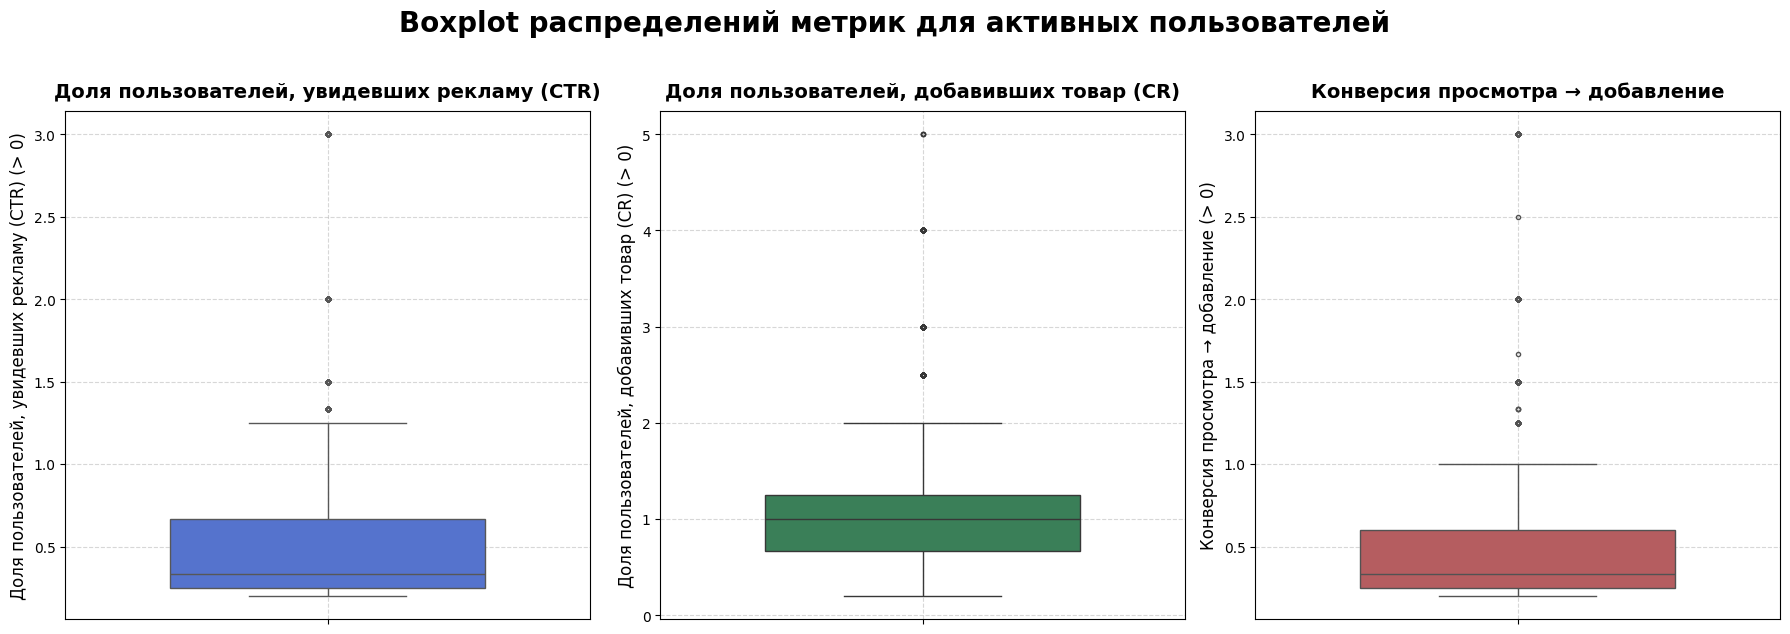

In [127]:
# =====================
# 📦 БЛОК 3.1.4: Boxplot метрик для активных пользователей (нулевой период)
# =====================

# 📌 Используем user_metrics_raw — расчётные метрики по пользователям
metrics = ['CTR', 'CR', 'Conv_view_to_add']
colors  = [metric_colors[m] for m in metrics]

# 1️⃣ Создаём холст с 3 subplot'ами в ряд
plt.figure(figsize=(18, 6))

for i, (metric, color) in enumerate(zip(metrics, colors), start=1):
    plt.subplot(1, len(metrics), i)

    # 📦 Берём только пользователей с ненулевыми значениями метрики
    data = user_metrics_raw.loc[user_metrics_raw[metric] > 0, metric]

    # 📊 Рисуем вертикальный boxplot
    sns.boxplot(
        y=data,
        color=color,
        width=0.6,
        fliersize=3
    )

    # 🏷️ Подписи и заголовки
    title = metric_labels.get(metric, metric)
    plt.title(title, fontsize=14, fontweight='bold', pad=10)
    plt.ylabel(f'{title} (> 0)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

# 2️⃣ Общий заголовок
plt.suptitle(
    'Boxplot распределений метрик для активных пользователей',
    fontsize=20,
    fontweight='bold',
    y=1.05
)

# 3️⃣ Отступы
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#### 🔍 Вывод по распределениям метрик

**Общие закономерности:**

* Метрики **CTR (clicks/views)**, **CR (adds/clicks)** и **Conv\_view\_to\_add (adds/views)** имеют **сильно скошенные распределения с правым хвостом**: большинство пользователей не совершают целевых действий, но наблюдаются редкие всплески активности.
* **Мода и медиана равны нулю**, что типично для маркетплейсов — большая часть пользователей ограничивается только просмотрами.
* Значения метрик **могут превышать 1.0** из-за дискретности событий (например, 1 клик и 2 добавления → CR = 2.0).

**Ключевые наблюдения:**

* Все метрики **не соответствуют нормальному распределению**, что требует использования устойчивых методов (например, дельта-метода).
* **Более 75% пользователей** не совершают активных действий — это подтверждено нулевыми медианами.
* **Boxplot-графики** выявили гиперактивных пользователей (выбросы), особенно по **CR** и **Conv\_view\_to\_add** — они могут быть интересны для персонализированных кампаний.

**Статистические особенности:**

* Метрики являются **отношениями двух случайных величин**, зависящих друг от друга.
* Поэтому **классические формулы для долей неприменимы**: необходимо учитывать дисперсии, ковариацию и использовать дельта-метод для анализа.

---


## **3.2. Расчёт дисперсий и доверительных интервалов (дельта-метод)**

### **3.2.1 Расчёт дисперсий и доверительных интервалов (дельта-метод)**

**Проблема:**
Метрики **CTR**, **CR** и **Conv\_view\_to\_add** являются отношениями случайных величин (ratio-метриками).
Классические формулы для долей к ним неприменимы, потому что:

* и числитель, и знаменатель — случайны;
* между ними возможна зависимость (ковариация);
* значения могут выходить за диапазон \[0, 1].

---

**Решение:**
Для оценки дисперсий используется **дельта-метод** — приближённая аналитическая формула, основанная на разложении функции в ряд Тейлора. Метод учитывает:

* дисперсии числителя и знаменателя,
* их ковариацию,
* средние значения.

---

**Целевые метрики для расчёта:**

* `CTR  = clicks / views`
* `CR   = adds / clicks`
* `Conv_view_to_add = adds / views`

---

**Для каждой метрики рассчитываем:**

* выборочное **среднее значение**,
* **дисперсию** по формуле `var_ratio(x, y)`,
* **стандартное отклонение** (корень из дисперсии),
* **размер выборки** (число пользователей с ненулевым знаменателем).

---

**Результаты будут использованы для:**

* построения **доверительных интервалов (CI)**,
* расчёта **минимального различимого эффекта (MDE)**,
* анализа **чувствительности A/B-теста к эффекту и выборке**.

---


In [128]:
# ===================== МЕТОДОЛОГИЧЕСКАЯ ЧАСТЬ
# 📦 БЛОК 3.2.1/1: Расчёт дисперсии ratio-метрик через дельта-метод (функция)
# =====================

# 📌 Используется в блоках расчёта дисперсий и стандартных ошибок для CTR, CR, Conv...
def var_ratio(x, y):  # x / y
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x  = np.var(x, ddof=1)
    var_y  = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0, 1]

    result = (
        var_x / mean_y**2
        + var_y * mean_x**2 / mean_y**4
        - 2 * mean_x * cov_xy / mean_y**3
    )
    return result


In [129]:
# =====================
# 📦 БЛОК 3.2.1/2: Расчёт дисперсий ratio-метрик через дельта-метод (нулевой период)
# =====================

# 📌 Используем функцию var_ratio(), определённую ранее в БЛОКЕ 41 (раздел 3.2.2)

# 1️⃣ Список ratio-метрик с указанием числителя и знаменателя
ratio_metrics = {
    'CTR':              ('clicks_count', 'views_count'),
    'CR':               ('adds_count',   'clicks_count'),
    'Conv_view_to_add': ('adds_count',   'views_count')
}

# 2️⃣ Вычисляем для каждой метрики: среднее, дисперсию и стандартное отклонение
records = []
for code, (num_col, den_col) in ratio_metrics.items():
    df_sub = user_metrics_raw[user_metrics_raw[den_col] > 0]  # исключаем нули в знаменателе
    x = df_sub[num_col]
    y = df_sub[den_col]
    mean_ratio = (x / y).mean()
    variance   = var_ratio(x, y)               # функция определена в Блоке 41
    std_dev    = np.sqrt(variance)
    n_users    = df_sub['client_id'].nunique()

    records.append({
        'Метрика':  metric_labels[code],
        'metric':   code,
        'mean':     mean_ratio,
        'variance': variance,
        'std':      std_dev,
        'n_users':  n_users
    })

# 3️⃣ Собираем таблицу с результатами
metrics_var_raw_df = pd.DataFrame(records)[
    ['Метрика', 'metric', 'mean', 'variance', 'std', 'n_users']
]

# 4️⃣ Вывод таблицы
print("📊 Таблица дисперсий ratio-метрик (дельта-метод):")
display(metrics_var_raw_df)


📊 Таблица дисперсий ratio-метрик (дельта-метод):


,Метрика,metric,mean,variance,std,n_users
0,"Доля пользователей, увидевших рекламу (CTR)",CTR,0.033769,0.030775,0.175429,3102735
1,"Доля пользователей, добавивших товар (CR)",CR,0.444304,0.334631,0.578473,228491
2,Конверсия просмотра → добавление,Conv_view_to_add,0.013081,0.013086,0.114394,3102735


### **3.2.2. Визуализация средних значений и std для метрик**

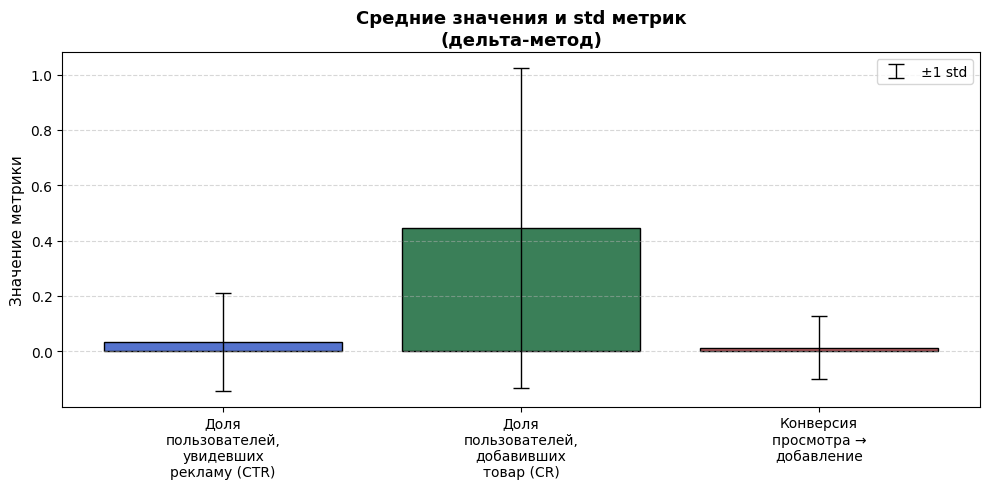

In [130]:
# =====================
# 📦 БЛОК 3.2.2: Средние и стандартные отклонения метрик (дельта-метод)
# =====================

# 1️⃣ Готовим данные: берём mean и std из metrics_var_raw_df
plot_df_raw = (
    metrics_var_raw_df
    .loc[:, ['metric', 'mean', 'std']]
    .copy()
)
plot_df_raw['Метрика'] = plot_df_raw['metric'].map(metric_labels)

# 2️⃣ Оборачиваем названия метрик для оси X
plot_df_raw['label_wrapped'] = plot_df_raw['Метрика'].apply(
    lambda s: "\n".join(textwrap.wrap(s, width=15))
)

# 3️⃣ Строим столбчатую диаграмму со столбцами и "усами"
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=plot_df_raw,
    x='label_wrapped',
    y='mean',
    hue='label_wrapped',  # 📌 явно передаём hue
    palette=[metric_colors[m] for m in plot_df_raw['metric']],
    edgecolor='black',
    legend=False           # отключаем дублирующую легенду
)

# 4️⃣ Добавляем errorbar — ±1 std
x_coords = np.arange(len(plot_df_raw))
ax.errorbar(
    x=x_coords,
    y=plot_df_raw['mean'],
    yerr=plot_df_raw['std'],
    fmt='none',
    c='black',
    capsize=6,
    linewidth=1,
    label='±1 std'
)

# 5️⃣ Оформление графика
ax.set_title('Средние значения и std метрик\n(дельта-метод)', fontsize=13, fontweight='bold')
ax.set_ylabel('Значение метрики', fontsize=11)
ax.set_xlabel('')
ax.set_xticks(x_coords)
ax.set_xticklabels(plot_df_raw['label_wrapped'], fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend()

# 6️⃣ Показываем
plt.tight_layout()
plt.show()


### **3.2.3. Доверительные интервалы (95%) для ratio-метрик (дельта-метод)**

**Цель:**
Построить 95% доверительные интервалы (CI) для метрик, чтобы оценить статистическую значимость наблюдаемого эффекта.

---

**Метод:**
Интервалы рассчитываются с использованием результатов **дельта-метода**.

1. **Стандартная ошибка (SE):**
   Для каждой метрики $r$:

$$
SE = \sqrt{ \frac{Var(r)}{n} }
$$

где:

* $Var(r)$ — дисперсия метрики (из `variance` в `metrics_var_df`),
* $n$ — количество наблюдений (`n_users`).

2. **Z-квантиль для 95% CI:**

$$
z_{\alpha/2} = \text{norm.ppf}(1 - \alpha / 2), \quad \alpha = 0.05
$$

3. **Формула CI:**

$$
CI = [\bar{r} - z_{\alpha/2} \cdot SE,\; \bar{r} + z_{\alpha/2} \cdot SE]
$$

где $\bar{r}$ — среднее значение метрики (`mean` из `metrics_var_df`).

---

**Результат:**
Итоговая таблица сохраняется в `ci_df` со следующими колонками:

* `metric` — код метрики;
* `mean` — среднее значение;
* `se` — стандартная ошибка;
* `ci_lower`, `ci_upper` — границы 95% CI.

---


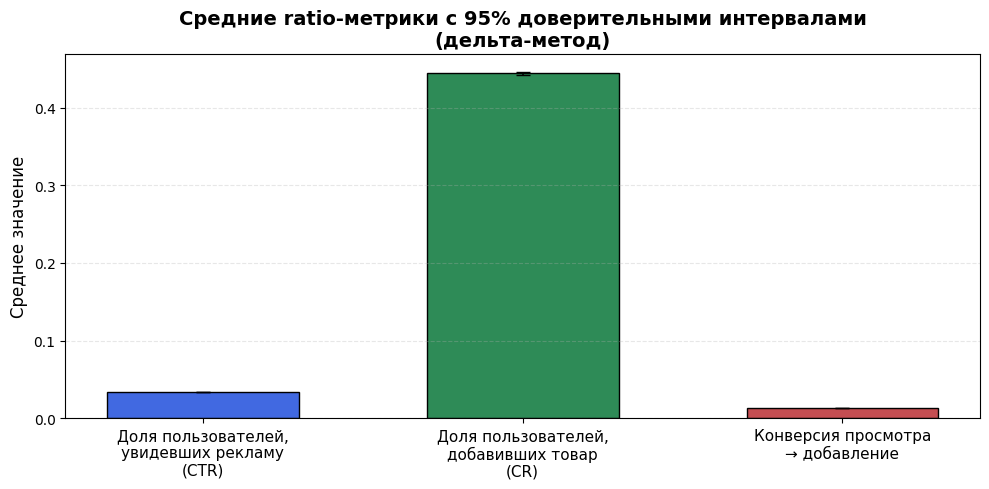

📊 95% доверительные интервалы для ratio-метрик:


,Метрика,mean,se,ci_lower,ci_upper
0,"Доля пользователей, увидевших рекламу (CTR)",0.033769,0.000100,0.033574,0.033964
1,"Доля пользователей, добавивших товар (CR)",0.444304,0.001210,0.441932,0.446676
2,Конверсия просмотра → добавление,0.013081,0.000065,0.012953,0.013208


In [131]:
# =====================
# 📦 БЛОК 3.2.3: Доверительные интервалы 95% по ratio-метрикам (дельта-метод)
# =====================

# 📌 Импорт квантиля из констант
z_alpha = Z_ALPHA_2  # из констант проекта

# 1️⃣ Расчёт CI по метрикам
ci_records = []
for _, row in metrics_var_raw_df.iterrows():
    code    = row['metric']
    mu      = row['mean']
    var     = row['variance']
    n       = row['n_users']
    se      = np.sqrt(var / n)
    lo, hi  = mu - z_alpha * se, mu + z_alpha * se

    ci_records.append({
        'metric':    code,
        'Метрика':   metric_labels[code],
        'mean':      mu,
        'se':        se,
        'ci_lower':  lo,
        'ci_upper':  hi
    })

ci_df_raw = pd.DataFrame(ci_records)

# 2️⃣ Подготовка подписей
ci_df_raw['label_wrapped'] = ci_df_raw['Метрика'].apply(
    lambda s: "\n".join(textwrap.wrap(s, width=20))
)

# 3️⃣ Данные для графика
labels    = ci_df_raw['label_wrapped'].tolist()
means     = ci_df_raw['mean'].values
err_lower = means - ci_df_raw['ci_lower'].values
err_upper = ci_df_raw['ci_upper'].values - means
errors    = np.vstack([err_lower, err_upper])

# 🎨 Цвета для столбцов
bar_colors = [metric_colors[m] for m in ci_df_raw['metric']]

# 4️⃣ Построение графика
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(labels))

# Столбики
ax.bar(x, means, color=bar_colors, edgecolor='black', width=0.6)

# Error-bar
ax.errorbar(
    x, means,
    yerr=errors,
    fmt='none',
    ecolor='black',
    elinewidth=1.2,
    capsize=5
)

# 5️⃣ Оформление
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('Среднее значение', fontsize=12)
ax.set_title('Средние ratio-метрики с 95% доверительными интервалами\n(дельта-метод)',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 6️⃣ Таблица
print("📊 95% доверительные интервалы для ratio-метрик:")
display(ci_df_raw[['Метрика','mean','se','ci_lower','ci_upper']])


**Интерпретация раздела (95% CI, дельта-метод).**

1. **CTR — доля пользователей, увидевших рекламу**

   * Оценка среднего: ≈ 0.0338 (3.38 %).
   * **95% CI** очень узкий (примерно \[0.0336; 0.0340]), что объясняется огромным числом пользователей (≈ 310 000).
   * Узкий CI говорит о том, что наша оценка CTR **стабильна** и для обнаружения изменений достаточно небольших эффектов (порядка 0.1–0.2 п.п.).

2. **CR — доля пользователей, добавивших товар**

   * Оценка среднего: ≈ 0.4443 (44.43 %).
   * **95% CI** чуть шире, но всё ещё довольно узкий (примерно \[0.4419; 0.4467]).
   * Большой разброс ис­пользования корзины объясняет чуть большую ширину CI, однако точность оценки всё равно высока.

3. **Conv\_view\_to\_add — конверсия просмотра в добавление**

   * Оценка среднего: ≈ 0.0131 (1.31 %).
   * **95% CI** немного уже, чем у CR, но за счёт тех же причин (огромного $n$) остаётся узким (примерно \[0.0130; 0.0132]).
   * Несмотря на низкий абсолютный уровень метрики, доверительный интервал даёт уверенность в том, что мы можем надёжно фиксировать даже небольшие изменения на этой стадии воронки.

**Почему так важно CI, а не просто «std»:**

* **Стандартное отклонение** (σ) показывает, насколько сильно ведут себя **отдельные пользователи** вокруг среднего.
* **Стандартная ошибка** (SE) и **95% CI** отражают **точность** оценки среднего при данном числе наблюдений.
* В A/B-тесте именно CI / SE важны, потому что они говорят, какое **минимальное изменение** среднего мы сможем зафиксировать как значимое.

Таким образом, график демонстрирует, что даже самые «глубокие» метрики (Conv\_view\_to\_add) оцениваются достаточно точно благодаря большому $n$, а доверительные интервалы позволяют с высокой уверенностью сравнивать контроль и тест.


#### 🔍 Выводы по CI:

* **Дельта-метод** — обоснованный выбор для оценки ratio-метрик с высокой дисперсией;
* Простое сравнение средних без доверительных интервалов может ввести в заблуждение (особенно по метрике CR);
* Благодаря закону больших чисел, **средние значения стабильны**, что даёт основу для точной оценки эффекта A/B-теста.

## **3.3. Расчёт минимального различимого эффекта (MDE)**

Для оценки чувствительности A/B-теста рассчитывается **минимально различимый эффект** (**MDE**) — наименьшее изменение **ratio-метрики**, которое можно статистически зафиксировать при заданных параметрах:

 * уровень значимости  α = 0.05;
 * мощность теста 1-β = 0.80.

Метрика считается чувствительной, если значение её MDE ниже целевого эффекта.


### **3.3.1. Что такое MDE и как он рассчитывается**

**MDE** — это наименьшее изменение метрики, которое тест способен достоверно выявить.

**Формула расчёта (дельта-метод, для двух равных групп):**

$$
MDE_{\text{abs}} = (z_{\alpha/2} + z_\beta) \cdot \sqrt{ \frac{2 \cdot Var(r)}{n} }
$$

$$
MDE_{\%} = \frac{MDE_{\text{abs}}}{\bar{r}} \cdot 100
$$

где:

* $\bar{r}$ — среднее значение метрики;
* $Var(r)$ — дисперсия метрики по дельта-методу;
* $n$ — размер выборки в **одной группе** (контроль или тест);
* $z_{\alpha/2} \approx 1.96$, $z_\beta \approx 0.84$ — квантиль нормального распределения.

📌 Расчёт MDE позволяет понять, какие эффекты можно будет зафиксировать, и стоит ли запускать эксперимент при текущем объёме аудитории.

### **3.3.2. Реализация: функция `get_MDE()`**

Для расчёта минимально различимого эффекта в проекте реализована универсальная функция **`get_MDE`**, основанная на формуле дельта-метода. Она учитывает параметры теста и характеристики метрики.


In [132]:
# ===================== МЕТОДОЛОГИЧЕСКИЙ МАТЕРИАЛ
# 📦 БЛОК 3.3.2: Функция расчёта минимального наблюдаемого эффекта (get_MDE)
# =====================

def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):

    """
    Возвращает минимально различимый эффект (MDE) для ratio-метрики.

    mu: float — среднее значение метрики
    std: float — стандартное отклонение метрики
    sample_size: int — общий размер выборки (включая все группы)
    n_groups: int — количество групп (например, 2)
    target_share: float — доля одной экспериментальной группы
    r: float — отношение размеров групп (если равны — 1)
    alpha: float — уровень значимости (по умолчанию 0.05)
    beta: float — уровень ошибки II рода (по умолчанию 0.2)

    return:
        mde_abs — минимально различимый эффект в абсолютных единицах
        mde_pct — то же в процентах от среднего
    """
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta  = stats.norm.ppf(1 - beta)
    comparisons = n_groups - 1
    sample_ratio_correction = r + 2 + 1 / r

    mde_abs = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(
        sample_size * (1 - target_share * (comparisons - 1))
    )
    mde_pct = mde_abs * 100 / mu
    return mde_abs, mde_pct


📌 Эта функция используется для оценки чувствительности теста при заданных параметрах и построения таблиц зависимости «эффект ↔ выборка».

---



### **3.3.3. MDE при текущем объёме выборки (20%)**

Для оценки чувствительности A/B-теста рассчитаны значения MDE по каждой метрике при охвате **20% пользователей** (поровну — 10% на контроль и 10% на тест).

**Параметры расчёта:**

* Общее число пользователей: 3 102 736
* Выборка: 20% = **620 547** пользователей (по 310 273 в каждую группу)
* Уровень значимости: $\alpha = 0.05$
* Мощность: $1 - \beta = 0.80$

---

### **3.3.4. Реализация расчёта MDE при заданной выборке (по 10%)**

In [133]:
# =====================
# 📦 БЛОК 3.3.4: Реализация расчёта MDE при заданной выборке (по 10%)
# =====================

# 1️⃣ Общая численность пользователей до эксперимента
total_users_raw = user_metrics_raw['client_id'].nunique()

# 2️⃣ 20% от общего — всего в тест + контроль → поровну по 10%
sample_size_total = int(total_users_raw * MAX_SHARE)
sample_size_per_group = sample_size_total // 2

# 3️⃣ Расчёт абсолютного и относительного MDE по дельта-методу
metrics_var_raw_df['MDE_abs'] = Z_SUM * np.sqrt(2 * metrics_var_raw_df['variance'] / sample_size_per_group)
metrics_var_raw_df['MDE_pct'] = metrics_var_raw_df['MDE_abs'] / metrics_var_raw_df['mean'] * 100

# 4️⃣ Форматирование таблицы для финального отображения
metrics_var_raw_df_pretty = (
    metrics_var_raw_df
    .round({'MDE_abs': 5, 'MDE_pct': 2})
    .rename(columns={
        'metric':   'Код метрики',
        'mean':     'Среднее значение',
        'variance': 'Дисперсия (дельта)',
        'n_users':  'Ист. число пользователей',
        'MDE_abs':  'MDE (абс.)',
        'MDE_pct':  'MDE (%)'
    })
    .assign(Метрика=lambda df: df['Код метрики'].map(metric_labels))
    [['Метрика', 'Код метрики', 'Среднее значение', 'Дисперсия (дельта)',
      'Ист. число пользователей', 'MDE (абс.)', 'MDE (%)']]
)

# 5️⃣ Вывод таблицы с результатами
print("📊 Расчёт минимально различимого эффекта (MDE) при заданном размере групп (по 10%):")
display(metrics_var_raw_df_pretty)


📊 Расчёт минимально различимого эффекта (MDE) при заданном размере групп (по 10%):


,Метрика,Код метрики,Среднее значение,Дисперсия (дельта),Ист. число пользователей,MDE (абс.),MDE (%)
0,"Доля пользователей, увидевших рекламу (CTR)",CTR,0.033769,0.030775,3102735,0.00125,3.70
1,"Доля пользователей, добавивших товар (CR)",CR,0.444304,0.334631,228491,0.00411,0.93
2,Конверсия просмотра → добавление,Conv_view_to_add,0.013081,0.013086,3102735,0.00081,6.22



**Результаты (по данным `metrics_var_raw_df_pretty`):**

| Метрика                               | Среднее | MDE (абс.) | MDE (%) |
| ------------------------------------- | ------- | ---------- | ------- |
| CTR (клики / показы)                  | 0.0338  | 0.00125    | 3.70%   |
| CR (добавления / клики)               | 0.4443  | 0.00411    | 0.93%   |
| Conv\_view\_to\_add (добавл. / показ) | 0.0131  | 0.00081    | 6.22%   |

---

📌 **Интерпретация:**

* ✅ **CR** — чувствительная метрика. При текущей выборке можно зафиксировать прирост от **+0.93%**, что достаточно для целевого эффекта (+2.5%)
* ⚠️ **CTR** и **Conv\_view\_to\_add** — менее чувствительные: они фиксируют только **большие эффекты (≥ 3–6%)**
* 🔎 При меньших изменениях (ниже MDE) велика вероятность ложноотрицательного вывода


### **3.3.5. Минимальный объём аудитории по заданному MDE (`get_sample_size`)**

Помимо оценки чувствительности при фиксированной выборке, полезно решить **обратную задачу**:
*сколько пользователей потребуется, чтобы зафиксировать прирост метрики заданного размера (например, +2.5% по CR)?*

Для этого используется функция `get_sample_size`, основанная на той же логике, что и расчёт MDE.

---

**Формула:**

$$
n = \frac{(r + 1)}{r} \cdot \frac{Var(r) \cdot (z_{\alpha/2} + z_\beta)^2}{(mde \cdot \bar{r})^2}
$$

где:

* $\bar{r}$ — среднее значение метрики;
* $Var(r)$ — её дисперсия;
* $mde$ — целевой эффект в долях (например, 0.025);
* $r$ — соотношение размеров групп (1, если равны);
* $z_{\alpha/2}$, $z_\beta$ — квантили нормального распределения.

---

📌 **Применение:**

* Строим таблицу зависимости «размер аудитории ↔ MDE»;
* Определяем, возможна ли фиксация слабого эффекта при заданном охвате (например, не более 20%).

📈 Вывод:
Функция `get_sample_size` позволяет **обосновать реалистичность теста** ещё до запуска — если требуемая выборка превышает лимит, эксперимент заранее обречён на низкую чувствительность.


In [134]:
# =====================
# 📦 БЛОК 3.3.5: Минимальный объём аудитории по заданному MDE (get_sample_size)
# =====================

def get_sample_size(mu, var, mde, r=1, alpha=0.05, beta=0.2):
    """
    Возвращает минимальный размер аудитории для ratio-метрики
    при заданных параметрах теста и целевом эффекте (mde).

    mu: float — среднее значение метрики
    var: float — дисперсия метрики
    mde: float — минимальный эффект (в долях от mu, например 0.025)
    r: float — соотношение размеров групп (обычно 1)
    alpha: float — уровень значимости (по умолчанию 0.05)
    beta: float — ошибка II рода (по умолчанию 0.2)

    return:
        sample_size: минимальный объём выборки на одну группу
    """
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta  = stats.norm.ppf(1 - beta)

    sample_size = (r + 1) / r * var * (t_alpha + t_beta)**2 / (mde * mu)**2
    return sample_size


---

### 3.3.6. Проверка ограничения по охвату пользователей (20%)

По условиям проекта, **эксперимент не должен затронуть более 20% аудитории**. Необходимо убедиться, что расчётная выборка укладывается в этот лимит.


In [135]:
# =====================
# 📦 БЛОК 3.3.6: Проверка ограничения A/B-теста по охвату пользователей
# =====================

# 1️⃣ Общее число пользователей до эксперимента
total_users_raw = user_metrics_raw['client_id'].nunique()
print("👥 Всего уникальных пользователей до эксперимента:", total_users_raw)

# 2️⃣ Параметры A/B-теста
test_params = {
    'n_groups':          2,               # тест и контроль
    'target_share':      0.5,             # одна из групп
    'r':                 1,               # группы равны
    'alpha':             ALPHA,
    'beta':              BETA,
    'sample_size_total': int(total_users_raw * MAX_SHARE)
}

# 3️⃣ Проверка лимита
print("📏 sample_size_total (ограничение по 20%):", test_params['sample_size_total'])
print("✅ Лимит соблюдён:",
      test_params['sample_size_total'] <= int(total_users_raw * MAX_SHARE))


👥 Всего уникальных пользователей до эксперимента: 3102736
📏 sample_size_total (ограничение по 20%): 620547
✅ Лимит соблюдён: True



#### 🔍 Выводы по MDE:

📉 **Параметры теста**:

* Уровень значимости α = 0.05
* Мощность теста 1 − β = 0.80 (β = 0.2)
* Продолжительность: 1 неделя (по условию проекта)

В разделе выполнен полный анализ **чувствительности A/B-теста** по метрикам CTR, CR и Conv\_view\_to\_add:

* ✅ **CR** (добавления из рекламы после клика) — обоснованно выбрана в качестве **ключевой метрики**:

  * при текущем охвате 20% (по 310 273 в каждую группу)
  * можно статистически зафиксировать прирост от **+0.93%**
  * соответствует целевому эффекту **+2.5%**, зафиксированному в аналогичных тестах

* ⚠️ **CTR** и **Conv\_view\_to\_add** имеют **низкую чувствительность**:

  * для статистической значимости требуются эффекты от **3.7% до 6.2%**
  * малые изменения по этим метрикам не будут зафиксированы — возможны ложноотрицательные выводы

* 📏 Ограничение в **20% охвата** соблюдено, тест запускается в допустимых пределах

📌 **Вывод:**
Эксперимент обладает достаточной мощностью для анализа по метрике **CR**. Остальные метрики следует рассматривать как вспомогательные — они подходят лишь для фиксации сильных эффектов.

## 3.4. Диапазон чувствительности A/B-теста (±MDE)

**🎯 Цель:**

Показать, **на каких участках изменения метрики A/B-тест чувствителен**, а где — нет.

Центральная зона ±MDE визуально отражает **диапазон нечувствительности** теста — изменения внутри этого диапазона не будут признаны статистически значимыми при заданных параметрах.

---

### 🧪 Параметры теста:

* Уровень значимости: $\alpha = 0.05$
* Мощность: $1 - \beta = 0.80$
* Размер выборки: **20% пользователей**

  * по **10% в контроль и тест** (группы равные)
  * используется общее число пользователей до эксперимента: $N_{\text{total}} = 3\,102\,736$

---

### 📌 Задача:

Спроектировать способность теста **обнаруживать эффект заданного размера**
(то есть определить, начиная с какого относительного прироста метрики эффект будет статистически различим).

In [136]:
# =====================
# 📦 БЛОК 3.4/1: Диапазон чувствительности A/B-теста — расчёт MDE
# =====================

# 📌 Функция расчёта MDE (дельта-метод, abs)
def get_MDE(variance, n_group, z_sum):
    """
    Возвращает минимально различимый эффект в абсолютном выражении
    при заданной дисперсии, размере группы и z-сумме.
    """
    return z_sum * np.sqrt(2 * variance / n_group)

# 1️⃣ Общее количество пользователей и размер группы
total_users_raw = user_metrics_raw['client_id'].nunique()
sample_size_total = int(total_users_raw * MAX_SHARE)
sample_size_per_group = sample_size_total // 2

# 2️⃣ Построение таблицы mde_var_raw_df с расчётом абсолютного и процентного MDE
mde_var_raw_df = metrics_var_raw_df.copy()
mde_var_raw_df['MDE_abs'] = mde_var_raw_df['variance'].apply(
    lambda var: get_MDE(var, sample_size_per_group, Z_SUM)
)
mde_var_raw_df['MDE_pct'] = mde_var_raw_df['MDE_abs'] / mde_var_raw_df['mean'] * 100
mde_var_raw_df['Метрика'] = mde_var_raw_df['metric'].map(metric_labels)

# 3️⃣ Просмотр результата
display(mde_var_raw_df)


,Метрика,metric,mean,variance,std,n_users,MDE_abs,MDE_pct
0,"Доля пользователей, увидевших рекламу (CTR)",CTR,0.033769,0.030775,0.175429,3102735,0.001248,3.695124
1,"Доля пользователей, добавивших товар (CR)",CR,0.444304,0.334631,0.578473,228491,0.004115,0.926082
2,Конверсия просмотра → добавление,Conv_view_to_add,0.013081,0.013086,0.114394,3102735,0.000814,6.220508


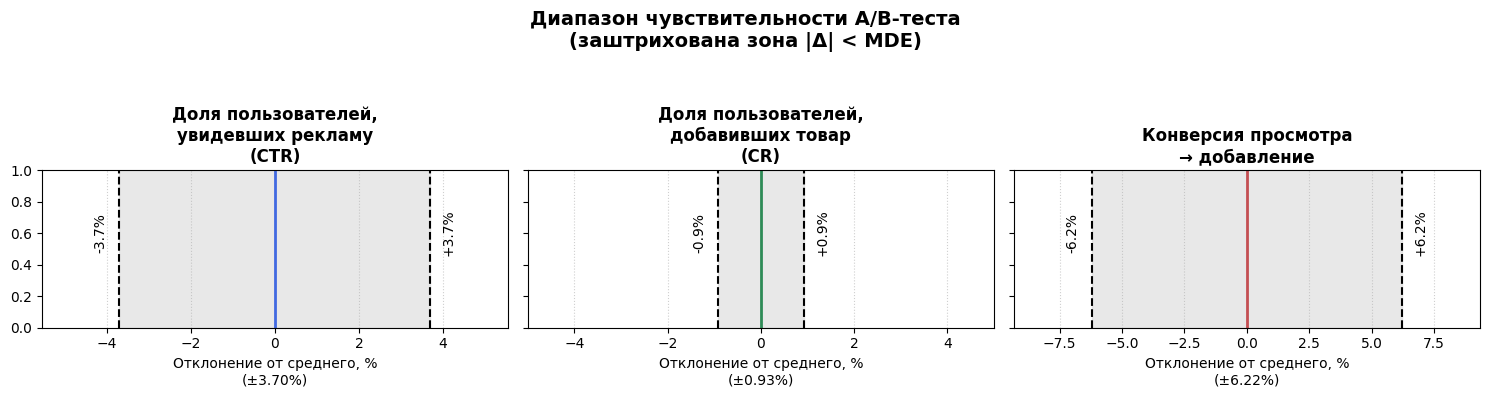

In [137]:
# =====================
# 📦 БЛОК 3.4/2: Диапазон чувствительности A/B-теста (визуализация ±MDE)
# =====================

# 1️⃣ Обогащаем mde_var_raw_df: метки и подписи
mde_var_raw_df['Метрика'] = mde_var_raw_df['metric'].map(metric_labels)
mde_var_raw_df['label_wrapped'] = mde_var_raw_df['Метрика'].apply(
    lambda s: "\n".join(textwrap.wrap(s, width=20))
)

# 2️⃣ Подготовка данных для визуализации
metrics        = mde_var_raw_df['metric'].tolist()
labels_wrapped = mde_var_raw_df['label_wrapped'].tolist()
mde_values     = mde_var_raw_df['MDE_pct'].values

# 3️⃣ Построение субплотов
n_panels = len(metrics)
fig, axes = plt.subplots(1, n_panels, figsize=(5 * n_panels, 4), sharey=True)
center = 0  # теперь центр по оси X — это нулевая дельта

for ax, metric, mde, title in zip(axes, metrics, mde_values, labels_wrapped):
    lower, upper = -mde, +mde
    margin       = max(mde * 1.5, 5)
    left, right  = -margin, +margin

    ax.axvspan(lower, upper, color='lightgray', alpha=0.5)
    ax.axvline(center, color=metric_colors.get(metric, 'blue'), linewidth=2)
    ax.axvline(lower,  color='black', linestyle='--')
    ax.axvline(upper,  color='black', linestyle='--')
    ax.set_xlim(left, right)

    # аннотации ±MDE
    y_mid    = ax.get_ylim()[1] * 0.6
    x_offset = margin * 0.05
    ax.text(lower - x_offset, y_mid, f'-{mde:.1f}%', ha='right',  va='center', rotation=90)
    ax.text(upper + x_offset, y_mid, f'+{mde:.1f}%', ha='left',   va='center', rotation=90)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(f'Отклонение от среднего, %\n(±{mde:.2f}%)', fontsize=10)
    ax.grid(axis='x', linestyle=':', alpha=0.6)

# 4️⃣ Общий заголовок
fig.suptitle(
    'Диапазон чувствительности A/B-теста\n(заштрихована зона |Δ| < MDE)',
    fontsize=14, fontweight='bold'
)

# 5️⃣ Отступы
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


#### 🔍 Вывод: чувствительность теста:

* **CTR** – минимально различимый эффект **±3,70 %**. Это значит, что тест надёжно обнаружит только изменения кликабельности более шести с половиной процентов от текущего уровня; менее крупные колебания останутся вне зоны «чувствительности».
* **CR** – самая «чувствительная» метрика: диапазон **±0,93 %** означает, что даже небольшой рост или падение конверсии добавления в корзину от клика будет зафиксирован надёжно.
* **Conv\_view\_to\_add** – наименее чувствительна: только изменения **от ±6,22 %** и выше попадут за пределы заштрихованной зоны и будут признаны статистически значимыми.

Заштрихованная область $|\Delta| < \mathrm{MDE}$ показывает, какие изменения тест **не сможет** отличить от случайного шума при текущем размере выборки. Изменения, выходящие **за пределы** ±MDE (линии на 100 % ±MDE), будут статистически различимы.

Таким образом, график наглядно демонстрирует «разрешающую способность» нашего эксперимента по каждой метрике и помогает понять, какие величины относительного изменения мы можем надёжно зафиксировать.

## 3.5. Зависимость между размером эффекта (MDE, %) и требуемым объёмом выборки

**🎯 Цель:**

Оценить, **какой объём выборки необходим**, чтобы достоверно зафиксировать прирост метрики заданной величины (например, **+2.5%**), и **соотнести его с лимитом** в 20% от всей пользовательской базы.

---

**📌 Анализируемые метрики:**

* **CTR** — клики / показы
* **CR** — добавления / клики
* **Conv\_view\_to\_add** — добавления / показы

---

**🧮 Методология:**

* Используется **обратная форма дельта-метода** — через функцию `get_sample_size`
* Для каждой метрики, при заданной дисперсии и среднем значении, рассчитывается **необходимый объём выборки** для выявления целевого эффекта в **+2.5%**
* Группы предполагаются **равными по размеру**

---

**📏 Задачи:**

* Построить таблицу зависимости:
  **Эффект (%) → необходимый размер аудитории**
* Сравнить полученные значения с ограничением на охват:
  **20% от 3 102 736 пользователей ≈ 620 547**
* Сделать вывод: **какие метрики чувствительны**, а какие требуют слишком больших выборок для надёжной фиксации небольших эффектов

---

📌 Этот анализ позволяет оценить **реалистичность теста для каждой метрики** и аргументировать, почему, например, CR — оптимальный выбор ключевой метрики.


---




### **3.5.1. Оценка объёма выборки для фиксации эффекта (по каждой метрике)**

Для каждой метрики рассчитан **необходимый объём выборки** для фиксации заданного эффекта (MDE, в % от текущего среднего значения) при стандартных параметрах теста:

* уровень значимости $\alpha = 0.05$,
* мощность $1 - \beta = 0.80$.

---

📐 В расчётах используется функция `get_sample_size` на основе дельта-метода.
Построены таблицы зависимости **«эффект → минимальный объём аудитории»** для следующих метрик:

* CTR — клики / показы
* CR — добавления / клики
* Conv\_view\_to\_add — добавления / показы

---

**📊 Диапазон рассматриваемых эффектов (MDE, %):**

$$
[1.5\%,\ 2.0\%,\ 2.5\%,\ 3.0\%,\ 4.0\%,\ 5.0\%,\ 6.5\%]
$$

Особое внимание уделяется эффекту **+2.5%**, так как он был зафиксирован в аналогичном A/B-тесте ранее.

---

📌 Все значения сравниваются с **лимитом в 20% от базы**:

$$
620\,547\ \text{пользователей (тест + контроль)}
$$


---




In [138]:
# =====================
# 📦 БЛОК 3.5.1: Оценка объёма выборки для разных уровней MDE по каждой метрике
# =====================

# 1️⃣ Целевые значения MDE (% от среднего)
mde_pct_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.5]

# 2️⃣ Лимит на выборку: максимум 10% на группу от общего числа пользователей
total_users_raw = user_metrics_raw['client_id'].nunique()
max_per_group = int(total_users_raw * MAX_SHARE / 2)  # 10%

# 3️⃣ Подготовка: сбор строк таблицы
table_rows = []

for pct in mde_pct_list:
    row = {'MDE (%)': pct}
    for code in metrics_var_raw_df['metric']:
        mu  = metrics_var_raw_df.loc[metrics_var_raw_df['metric'] == code, 'mean'].values[0]
        var = metrics_var_raw_df.loc[metrics_var_raw_df['metric'] == code, 'variance'].values[0]
        label = metric_labels.get(code, code)

        # Абсолютный эффект
        mde_abs = mu * pct / 100

        # Расчёт размера выборки (дельта-метод)
        n_group = int(np.ceil((Z_SUM**2) * 2 * var / (mde_abs**2)))
        fits = "✅" if n_group <= max_per_group else "❌"

        # Названия колонок: '<метрика> (n)' и '<метрика> ok?'
        row[f'{label} (n)'] = n_group
        row[f'{label} ok?'] = fits
    table_rows.append(row)

# 4️⃣ Создание DataFrame
sample_size_summary = pd.DataFrame(table_rows)

# 5️⃣ Построение многоуровневого заголовка
columns = [('MDE (%)', '')]
for code in metrics_var_raw_df['metric']:
    label = metric_labels.get(code, code)
    columns.append((label, 'n_per_group'))
    columns.append((label, '≤ лимит?'))

sample_size_summary.columns = pd.MultiIndex.from_tuples(columns)

# 6️⃣ Вывод
print(f"🔍 Всего пользователей до эксперимента: {total_users_raw:,}")
print(f"🔍 Максимальный размер на одну группу (10%): {max_per_group:,}")
display(sample_size_summary)


🔍 Всего пользователей до эксперимента: 3,102,736
🔍 Максимальный размер на одну группу (10%): 310,273


MDE (%) Доля пользователей, увидевших рекламу (CTR)           \
                                          n_per_group ≤ лимит?   
0     0.5                                    16945794        ❌   
1     1.0                                     4236449        ❌   
2     1.5                                     1882866        ❌   
3     2.0                                     1059113        ❌   
4     2.5                                      677832        ❌   
5     3.0                                      470717        ❌   
6     4.0                                      264779        ✅   
7     5.0                                      169458        ✅   
8     6.5                                      100271        ✅   

  Доля пользователей, добавивших товар (CR)           \
                                n_per_group ≤ лимит?   
0                                   1064395        ❌   
1                                    266099        ✅   
2                                    118267        ✅   
3                                     66525        ✅   
4                                     42576        ✅   
5                                     29567        ✅   
6                                     16632        ✅   
7                                     10644        ✅   
8                                      6299        ✅   

  Конверсия просмотра → добавление           
                       n_per_group ≤ лимит?  
0                         48023711        ❌  
1                         12005928        ❌  
2                          5335968        ❌  
3                          3001482        ❌  
4                          1920949        ❌  
5                          1333992        ❌  
6                           750371        ❌  
7                           480238        ❌  
8                           284164        ✅

**Интерпретация результатов:**

* **Чем меньше ожидаемый эффект (MDE, %), тем больше объём выборки, необходимый для его статистической фиксации.**
* Каждая ячейка в таблице показывает, достаточно ли пользователей в пределах **лимита в 620 547 (20% от базы)**, чтобы зафиксировать заданный прирост метрики.

**📌 Обозначения:**

* ✅ — Тест **сможет** зафиксировать эффект заданной величины при текущем лимите и параметрах ($\alpha = 0.05, \beta = 0.2$);
* ❌ — Тест **не сможет** зафиксировать эффект такого масштаба при текущем объёме аудитории.


### *3.5.2. Зависимость объёма выборки от величины эффекта (MDE, %)*

Графики, отображающие, как изменяется требуемый размер выборки для фиксации различимых эффектов разной величины по каждой метрике.

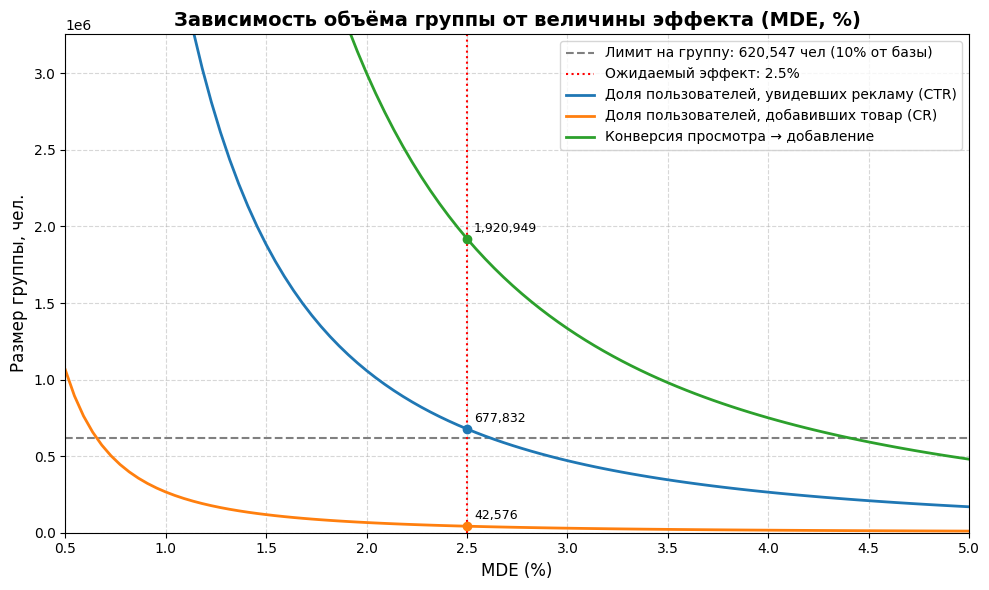

📊 n_per_group для фиксации эффекта 2.5% и проверка лимита:



,Метрика,MDE (%),n_per_group,≤ лимит?
0,"Доля пользователей, увидевших рекламу (CTR)",2.5,677832,❌
1,"Доля пользователей, добавивших товар (CR)",2.5,42576,✅
2,Конверсия просмотра → добавление,2.5,1920949,❌


In [139]:
# =====================
# 📦 БЛОК 3.5.2: Зависимость объёма выборки от величины эффекта (MDE, %)
# =====================

# 1️⃣ Диапазон значений MDE (%) и целевой эффект
mde_pct_range = np.linspace(0.5, 5.0, 100)  # от 0.5% до 5%
fact_mde = 2.5                              # фактически наблюдаемый/ожидаемый эффект

# 2️⃣ Расчёт объёма выборки при заданном эффекте по каждой метрике
intersection = []

for code in metrics_var_raw_df['metric']:
    mu  = metrics_var_raw_df.loc[metrics_var_raw_df['metric'] == code, 'mean'].values[0]
    var = metrics_var_raw_df.loc[metrics_var_raw_df['metric'] == code, 'variance'].values[0]
    label = metric_labels.get(code, code)

    abs_fact = fact_mde * mu / 100
    n_fact = 2 * Z_SUM**2 * var / (abs_fact**2)

    intersection.append({
        'Метрика': label,
        'MDE (%)': fact_mde,
        'n_per_group': int(np.ceil(n_fact))
    })

# 3️⃣ Визуализация: График зависимости размера группы от MDE
fig, ax = plt.subplots(figsize=(10, 6))

# Горизонтальная линия — лимит на группу (20% / 2)
ax.axhline(
    sample_size_total,
    color='gray',
    linestyle='--',
    label=f'Лимит на группу: {sample_size_total:,} чел (10% от базы)'
)

# Вертикальная линия — фактический эффект
ax.axvline(
    fact_mde,
    color='red',
    linestyle=':',
    label=f'Ожидаемый эффект: {fact_mde}%'
)

# Построение кривых по метрикам
for code in metrics_var_raw_df['metric']:
    mu  = metrics_var_raw_df.loc[metrics_var_raw_df['metric'] == code, 'mean'].values[0]
    var = metrics_var_raw_df.loc[metrics_var_raw_df['metric'] == code, 'variance'].values[0]
    label = metric_labels.get(code, code)

    abs_eff = mde_pct_range * mu / 100
    n_group = 2 * Z_SUM**2 * var / (abs_eff**2)

    # Линия зависимости
    ax.plot(mde_pct_range, n_group, label=label, linewidth=2)

    # Точка на фактическом эффекте
    abs_fact = fact_mde * mu / 100
    n_fact = 2 * Z_SUM**2 * var / (abs_fact**2)

    ax.plot(fact_mde, n_fact, 'o', color=ax.get_lines()[-1].get_color())
    ax.annotate(
        f"{int(np.ceil(n_fact)):,}",
        (fact_mde, n_fact),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

# 4️⃣ Оформление
ax.set_title("Зависимость объёма группы от величины эффекта (MDE, %)", fontsize=14, fontweight='bold')
ax.set_xlabel("MDE (%)", fontsize=12)
ax.set_ylabel("Размер группы, чел.", fontsize=12)
ax.set_xlim(mde_pct_range.min(), mde_pct_range.max())
ax.set_ylim(0, total_users_raw * 1.05)
ax.grid(axis='both', linestyle='--', alpha=0.5)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# 5️⃣ Таблица расчётов на ожидаемом эффекте
intersection_df = pd.DataFrame(intersection)

# 6️⃣ Таблица с проверкой лимита на размер группы
# Добавляем флаг соответствия лимиту
intersection_df['≤ лимит?'] = intersection_df['n_per_group'].apply(
    lambda x: '✅' if x <= sample_size_total else '❌'
)

# 7️⃣ Переупорядочим колонки для наглядности
intersection_df = intersection_df[['Метрика', 'MDE (%)', 'n_per_group', '≤ лимит?']]

# 8️⃣ Вывод
print("📊 n_per_group для фиксации эффекта 2.5% и проверка лимита:\n")
display(intersection_df)


**Интерпретация:**

* Для фиксации эффекта **+2.5%** по **CTR** требуется \~678 тыс. пользователей, что **превышает лимит** выборки.
* По **CR** объём выборки составляет всего \~43 тыс. — **укладывается в лимит** (20% от базы).
* **Конверсия просмотров в добавления** требует наибольшего объема — **более 1.9 млн пользователей**, что делает её **малочувствительной** к небольшим изменениям.

🔎 **Вывод:**
- Тестирование с эффектом +2.5% допустимо по метрике **CR**.
- Для **CTR** и **Conv\_view\_to\_add** такой эффект будет трудно зафиксировать без увеличения выборки или срока теста.

In [140]:
# ПРОВЕРКА Проверим metrics_var_df по метрике CR
metrics_var_raw_df[metrics_var_raw_df['metric'] == 'CR']


,Метрика,metric,mean,variance,std,n_users,MDE_abs,MDE_pct
1,"Доля пользователей, добавивших товар (CR)",CR,0.444304,0.334631,0.578473,228491,0.004115,0.926082


## **📝 ОБЩИЙ ВЫВОД (часть 1)**

В части 1 проведена подготовка и оценка чувствительности A/B-теста по ключевым пользовательским метрикам. Анализ показал, что при заданных параметрах (1 неделя, 20% аудитории) тест способен **надёжно зафиксировать целевой эффект +2.5% по метрике CR**.

---

### 🔹 Ключевая метрика:

Выбрана **CR** — конверсия в добавление товара после клика.
Она отражает ключевое поведение пользователей и напрямую влияет на выручку, что делает её обоснованным выбором для оценки эффекта от изменения расположения рекламы.

---

### 🔹 Ограничения и условия теста:

* Общее число пользователей до эксперимента: **3 102 736**
* Допустимый охват: **не более 20%** (всего 620 547 пользователей, по 310 273 на группу)
* Целевой эффект: **+2.5% по метрике CR**, на основе аналогичного исторического теста

---

### 🔹 Расчёт MDE по метрике CR:

* Абсолютное значение: **≈ 0.00412**
* Относительное: **≈ 0.93%**

📌 Это означает: при расчётной дисперсии на исторических данных (n = **228 491**) минимально различимый эффект составил ≈ **0.93%**, а значит, при текущем охвате (по **310 273** пользователей в группу) целевой эффект **+2.5%** будет достоверно зафиксирован.

---

### 🔹 Сравнение с целевым эффектом +2.5%:

* Для фиксации прироста +2.5% требуется всего **\~42 576 пользователей на группу**
* Это существенно меньше доступного лимита (**620 547 пользователей**) — запас по выборке есть

---

### **✅ Финальные выводы:**

* **✅ Эксперимент спроектирован корректно** — параметры теста, ограничения и чувствительность согласованы
* **✅ Тест обладает достаточной мощностью**, чтобы выявить целевой эффект по ключевой метрике
* **⚠️ Интерпретация эффектов < 0.93% по CR нецелесообразна** — тест не обеспечит статистической достоверности таких изменений

---


# **🔹 ЧАСТЬ 2: АНАЛИЗ РЕЗУЛЬТАТОВ A/B-ТЕСТА (по группам test / control)**

## **4. Загрузка и подготовка данных A/B-теста**

In [141]:
# ⚙️ Загрузка данных
# Актуальный путь к файлу (final_results_to_analyze.csv) ПОСЛЕ эксперемента (с корректным разделителем исключ. ";")
df_results = pd.read_csv('/content/drive/MyDrive/ПОРТФОЛИО/портфолио в Python/AB_test/Источники/final_results_to_analyze.csv', sep=';')


In [142]:
# 🔢 Преобразование столбца date в datetime ===

# 1) Конвертируем строковый столбец 'date' в формат datetime
#    errors='coerce' — некорректные значения станут NaT, не вызовут ошибку
df_results['date'] = pd.to_datetime(df_results['date'], errors='coerce')

# 2) (Опционально) Нормализуем до даты без времени, если нужно
df_results['date'] = df_results['date'].dt.normalize()

# 3) Проверяем результат
print("Тип колонки date после конвертации:", df_results['date'].dtype)
print("Диапазон дат в df_results:", df_results['date'].min(), "—", df_results['date'].max())


Тип колонки date после конвертации: datetime64[ns]
Диапазон дат в df_results: 2024-07-24 00:00:00 — 2024-07-30 00:00:00


In [143]:
# 🔢 Общая информация о таблице.
print(df_results.shape)
print(df_results.columns)

print("\n📦 Типы данных:")
print(df_results.dtypes)

print("\n🔍 Кол-во пропусков:")
print(df_results.isna().sum())

(981510, 11)
Index(['date', 'client_id', 'ab_group', 'is_view_ads', 'cnt_view_ads',
       'is_adds_ads', 'cnt_adds_ads', 'sum_adds_ads', 'is_orders_ads',
       'cnt_orders_ads', 'sum_orders_ads'],
      dtype='object')

📦 Типы данных:
date              datetime64[ns]
client_id                  int64
ab_group                  object
is_view_ads                int64
cnt_view_ads               int64
is_adds_ads                int64
cnt_adds_ads               int64
sum_adds_ads               int64
is_orders_ads              int64
cnt_orders_ads             int64
sum_orders_ads             int64
dtype: object

🔍 Кол-во пропусков:
date              0
client_id         0
ab_group          0
is_view_ads       0
cnt_view_ads      0
is_adds_ads       0
cnt_adds_ads      0
sum_adds_ads      0
is_orders_ads     0
cnt_orders_ads    0
sum_orders_ads    0
dtype: int64


In [144]:
# === ПРОВЕРКА ===
# Получаем список уникальных групп эксперимента
groups = df_results['ab_group'].unique().tolist()

# Проверяем, есть ли стандартные названия 'control' и 'test'
if 'control' in groups and 'test' in groups:
    ctrl, tst = 'control', 'test'
# Если группы названы иначе, но их двое — тоже принимаем
elif len(groups) == 2:
    ctrl, tst = groups
# Если групп не две — ошибка
else:
    raise ValueError(f"Ожидаются две группы control/test, но найдены: {groups}")

# Просмотр полученных данных
print("📊 Группы в проекте:")
groups


📊 Группы в проекте:


['test', 'control']

#### 🔍 Вывод: Проверка и подготовка данных A/B-теста:

📚 **Описание данных:**

* Загружено **981 510 строк** с результатами A/B-эксперимента
* Всего **11 столбцов**, включая идентификаторы, флаги событий и числовые показатели

📌 **Структура данных:**

* `date` — преобразован в тип `datetime`
* `client_id` — целочисленный (`int64`)
* `ab_group` — строковый (`object`), 2 группы: `'test'` и `'control'`
* Остальные признаки — флаги и счётчики, тип `int64`:

  * `is_view_ads`, `cnt_view_ads`, ...
  * `is_adds_ads`, `cnt_adds_ads`, ...
  * `is_orders_ads`, `cnt_orders_ads`, ...

✅ **Пропусков в данных не обнаружено** — все значения присутствуют, данные готовы к анализу.

---



## **5. Базовое сравнение бизнес-метрик**

### **5.1. Агрегация результатов теста на уровне пользователя и групп**

Для анализа рассчитаны ключевые метрики на основе агрегированных пользовательских данных по группам.

👥 Агрегация выполнена в разрезе `ab_group` и `client_id`:

* учтены флаги активности (`viewed_days`, `added_days`, `ordered_days`);
* суммированы значения по количеству показов, добавлений, заказов и выручке за весь период эксперимента.

📦 Результат сохранён в таблице `user_level`, которая содержит по одной строке на пользователя в каждой группе (`test`, `control`) и служит основой для дальнейших расчётов метрик.

---

In [145]:
# =====================
# 📦 БЛОК 5.1:  Агрегация по пользователям и группам (эксперимент)
# =====================

# 1️⃣ Одна строка на (ab_group, client_id)
user_level = (
    df_results
      .groupby(['ab_group','client_id'], as_index=False)
      .agg(
         # Флаги активности (1, если событие было хотя бы 1 раз за весь период)
         viewed_days   = ('is_view_ads',   'max'),
         added_days    = ('is_adds_ads',   'max'),
         ordered_days  = ('is_orders_ads', 'max'),

         # Абсолютные значения за всё время
         impressions   = ('cnt_view_ads',  'sum'),
         adds          = ('cnt_adds_ads',  'sum'),
         orders        = ('cnt_orders_ads','sum'),
         revenue       = ('sum_orders_ads', 'sum')
      )
)

# 2️⃣ Подготовка читаемых названий столбцов
readable_cols = {
    'viewed_days':   'Был показ рекламы (день)',
    'added_days':    'Было добавление (день)',
    'ordered_days':  'Был заказ (день)',
    'impressions':   col_labels['cnt_view_ads'],
    'adds':          col_labels['cnt_adds_ads'],
    'orders':        col_labels['cnt_orders_ads'],
    'revenue':       col_labels['sum_orders_ads']
}

# 3️⃣ Просмотр первых строк таблицы
print("📊 Агрегация данных эксперимента по группам и пользователям:")
display(user_level.rename(columns=readable_cols).head())


📊 Агрегация данных эксперимента по группам и пользователям:


,ab_group,client_id,Был показ рекламы (день),Было добавление (день),Был заказ (день),Всего показов рекламы,Всего добавлений в корзину,Всего заказов из рекламы,Суммарная выручка из заказов
0,control,0,1,0,0,1,0,0,0
1,control,3,0,0,0,0,0,0,0
2,control,4,0,0,0,0,0,0,0
3,control,5,1,0,0,4,0,0,0
4,control,6,0,0,0,0,0,0,0


📌 Таблица **`user_level`** служит базой для расчёта всех последующих метрик: CTR, CR, конверсий, выручки и сравнения между группами.

### **5.2. Расчёт пользовательских метрик и статистик по группам**

Для анализа поведения пользователей выполнен расчёт ключевых метрик **по группам** (`control` и `test`) на агрегированном уровне. В таблице представлены:

* средние значения метрик на одного пользователя;
* абсолютное различие $\Delta = \text{Test} - \text{Control}$;
* относительное различие $\Delta\% = \frac{\Delta}{\text{Control}} \cdot 100$.

--

In [146]:
# =====================
# 📦 БЛОК 5.2/1: Сводка абсолютных метрик по группам (натуральные значения)
# =====================

# 1️⃣ Агрегация: группировка по группам
group_abs_exp = (
    df_results
    .groupby('ab_group')
    .agg(
        Уникальные_пользователи = ('client_id', 'nunique'),
        Дней_с_просмотрами       = ('is_view_ads', 'sum'),
        Всего_показов            = ('cnt_view_ads', 'sum'),
        Дней_с_добавлениями      = ('is_adds_ads', 'sum'),
        Всего_добавлений         = ('cnt_adds_ads', 'sum'),
        Стоимость_добавлений     = ('sum_adds_ads', 'sum'),
        Дней_с_заказами          = ('is_orders_ads', 'sum'),
        Всего_заказов            = ('cnt_orders_ads', 'sum'),
        Выручка_из_заказов       = ('sum_orders_ads', 'sum'),
    )
).reset_index()

# 2️⃣ Переход в long-формат
df_abs_exp = group_abs_exp.melt(
    id_vars='ab_group',
    var_name='Показатель',
    value_name='Значение'
)

# 3️⃣ Сохраняем порядок строк
original_order = group_abs_exp.columns[1:].tolist()
df_abs_exp['Показатель'] = pd.Categorical(df_abs_exp['Показатель'], categories=original_order, ordered=True)
df_abs_exp = df_abs_exp.sort_values(['Показатель', 'ab_group']).reset_index(drop=True)

# 4️⃣ Широкая таблица с разницей
pivot_abs_exp = (
    df_abs_exp
    .pivot(index='Показатель', columns='ab_group', values='Значение')
    .assign(**{
        'Разница (test–control)': lambda df: df['test'] - df['control']
    })
    .reset_index()
)

# 5️⃣ Вывод
print("📊 Абсолютные значения ключевых показателей по группам (натуральные единицы):\n")
display(
    pivot_abs_exp.style
    .format({
        'control': '{:,.0f}',
        'test': '{:,.0f}',
        'Разница (test–control)': '{:+,.0f}'
    })
    .set_caption("Сводная таблица абсолютных значений (control / test / Δ)\n")
)


📊 Абсолютные значения ключевых показателей по группам (натуральные единицы):



ab_group,Показатель,control,test,Разница (test–control)
0,Уникальные_пользователи,"200,786","200,474",-312
1,Дней_с_просмотрами,"25,389","25,852",+463
2,Всего_показов,"43,469","43,805",+336
3,Дней_с_добавлениями,"7,060","7,085",+25
4,Всего_добавлений,"15,799","16,337",+538
5,Стоимость_добавлений,"2,462,420","2,526,393","+63,973"
6,Дней_с_заказами,"6,079","6,171",+92
7,Всего_заказов,"5,579","5,881",+302
8,Выручка_из_заказов,"1,589,899","1,687,895","+97,996"


In [147]:
# =====================
# 📦 БЛОК 5.2/2: Сводка по метрикам + дисперсии (после эксперимента)
# =====================

# 1️⃣ Агрегация по группам (групповая сводка)
group_base_exp = (
    user_level
    .groupby('ab_group')
    .agg(
        users = ('client_id', 'nunique'),

        Доля_с_просмотрами  = ('viewed_days',  lambda x: (x > 0).mean()),
        Доля_с_добавлениями = ('added_days',   lambda x: (x > 0).mean()),
        Доля_с_заказами     = ('ordered_days', lambda x: (x > 0).mean()),

        Среднее_дней_просмотра  = ('viewed_days',  'mean'),
        Среднее_дней_добавления = ('added_days',   'mean'),
        Среднее_дней_заказов    = ('ordered_days', 'mean'),

        Среднее_показов    = ('impressions', 'mean'),
        Среднее_добавлений = ('adds',        'mean'),
        Среднее_заказов    = ('orders',      'mean'),
        Средняя_выручка    = ('revenue',     'mean')
    )
)

# 2️⃣ Расчёт user-level метрик для дисперсий (на основе user_level)
user_metrics_exp = user_level.copy()
user_metrics_exp['CTR']              = user_metrics_exp['viewed_days']
user_metrics_exp['CR']               = user_metrics_exp['added_days']
user_metrics_exp['Conv_view_to_add'] = user_metrics_exp['adds'] / user_metrics_exp['impressions']
user_metrics_exp['Revenue_per_user'] = user_metrics_exp['revenue']

metric_cols = ['CTR', 'CR', 'Conv_view_to_add', 'Revenue_per_user']

# 3️⃣ Расчёт дисперсий и средних
rows = []
for m in metric_cols:
    values = user_metrics_exp[m].dropna()
    mu = values.mean()

    if m in ['CTR', 'CR']:
        var = mu * (1 - mu)  # формула Бернулли
    else:
        var = values.var(ddof=1)

    rows.append({
        'metric': m,
        'mean': mu,
        'variance': var,
        'sample_size': len(values),
        'std': np.sqrt(var)
    })

metrics_var_exp_df = pd.DataFrame(rows)

# 4️⃣ Таблица для визуализации
metrics_exp_eng = [
    'users',
    'Среднее_дней_просмотра', 'Доля_с_просмотрами',
    'Среднее_дней_добавления', 'Доля_с_добавлениями',
    'Среднее_дней_заказов', 'Доля_с_заказами',
    'Среднее_показов', 'Среднее_добавлений',
    'Среднее_заказов', 'Средняя_выручка'
]

df_eng_metrics_exp = (
    group_base_exp[metrics_exp_eng]
    .reset_index()
    .rename(columns={'ab_group': 'Группа'})
)

pivot_exp_eng = (
    df_eng_metrics_exp
    .melt(id_vars='Группа', var_name='Метрика', value_name='Значение')
    .pivot(index='Метрика', columns='Группа', values='Значение')
)

pivot_exp_eng['Δ (test–control)'] = pivot_exp_eng['test'] - pivot_exp_eng['control']
pivot_exp_eng['Δ (%)'] = (pivot_exp_eng['Δ (test–control)'] / pivot_exp_eng['control'] * 100).round(2)

pivot_exp_eng = pivot_exp_eng.loc[metrics_exp_eng].round(4)

df_eng_metrics_exp = pivot_exp_eng.reset_index().rename(columns={
    'control': 'Control',
    'test':    'Test'
})

# 5️⃣ Вывод
print("📊 Сводная таблица метрик по группам (эксперимент) с Δ и Δ%:")
display(
    df_eng_metrics_exp.style
    .format({
        'Control': '{:.4f}',
        'Test':    '{:.4f}',
        'Δ (test–control)': '{:.4f}',
        'Δ (%)': '{:+.1f}%'
    })
    .highlight_max(subset=['Control', 'Test', 'Δ (%)'], axis=1, color='lightgreen')
)


📊 Сводная таблица метрик по группам (эксперимент) с Δ и Δ%:


Группа,Метрика,Control,Test,Δ (test–control),Δ (%)
0,users,200786.0000,200474.0000,-312.0000,-0.2%
1,Среднее_дней_просмотра,0.0947,0.0967,0.0020,+2.1%
2,Доля_с_просмотрами,0.0947,0.0967,0.0020,+2.1%
3,Среднее_дней_добавления,0.0284,0.0285,0.0001,+0.5%
4,Доля_с_добавлениями,0.0284,0.0285,0.0001,+0.5%
5,Среднее_дней_заказов,0.0246,0.0249,0.0003,+1.2%
6,Доля_с_заказами,0.0246,0.0249,0.0003,+1.2%
7,Среднее_показов,0.2165,0.2185,0.0020,+0.9%
8,Среднее_добавлений,0.0787,0.0815,0.0028,+3.6%
9,Среднее_заказов,0.0278,0.0293,0.0015,+5.6%



**Комментарий:**

* Участники теста:

    * Контроль: 200 786 уникальных пользователей
    * Тест: 200 474 уникальных пользователей

* Распределение между группами сбалансировано, перекосов нет;
* Различия между группами положительные по всем основным бизнес-метрикам (добавления, заказы, выручка);
* Эффекты находятся в диапазоне от **+0.5% до +6.3%**, что потенциально может быть значимым;
* Следующий шаг — проверить статистическую значимость этих различий (через доверительные интервалы или критерии).


### **5.3. Расчёт и сравнение ключевых бизнес-метрик по группам (CTR, CR, Revenue)**

На этом этапе выполняется расчёт **основных бизнес-метрик** по группам (`test` / `control`) на основе агрегированных пользовательских данных.

---

### 🔍 Особенность: отсутствуют клики

В данных эксперимента **не зафиксированы события кликов**, поэтому традиционный CTR как `clicks / views` рассчитать невозможно.
📌 В рамках проекта под CTR принимается **доля пользователей, которым была показана реклама**:

$$
CTR = \frac{\text{is_view_ads}}{\text{users}}
$$

---

### 📊 Рассчитываемые метрики:

| Метрика                 | Формула                     | Смысл                                 |
| ----------------------- | --------------------------- | ------------------------------------- |
| **CTR**                 | `is_view_ads / users`       | Доля пользователей, увидевших рекламу |
| **CR**                  | `is_adds_ads / users`       | Доля пользователей, добавивших товар  |
| **Conv\_view\_to\_add** | `is_adds_ads / is_view_ads` | Конверсия из показа в добавление      |
| **Revenue\_per\_user**  | `sum_orders_ads / users`    | Средняя выручка на пользователя       |

---

📌 Эти метрики рассчитаны на агрегированных данных по группам и будут использованы далее для оценки **статистической значимости изменений** между `test` и `control`.

---


In [148]:
# =====================
# 📦 БЛОК 5.3: Бизнес-метрики после эксперимента (группы test/control)
# =====================

# 1️⃣ Копируем сводку после эксперимента
group_base_exp_biz = group_base_exp.copy()

# 2️⃣ Вычисляем бизнес-метрики (по согласованным формулам проекта)
group_base_exp_biz['CTR']                = group_base_exp_biz['Доля_с_просмотрами']
group_base_exp_biz['CR']                 = group_base_exp_biz['Доля_с_добавлениями']
group_base_exp_biz['Conv_view_to_add']   = group_base_exp_biz['CR'] / group_base_exp_biz['CTR']
group_base_exp_biz['Revenue_per_user']   = group_base_exp_biz['Средняя_выручка']
group_base_exp_biz['Average_Order_Value'] = (
    group_base_exp_biz['Средняя_выручка'] / group_base_exp_biz['Среднее_заказов']
)

# 3️⃣ Метрики в заданном порядке
metrics_exp_biz = [
    'CTR',
    'CR',
    'Conv_view_to_add',
    'Revenue_per_user',
    'Average_Order_Value'
]

# 4️⃣ Преобразование формата: melt → pivot
df_biz_metrics_exp = (
    group_base_exp_biz[metrics_exp_biz]
    .reset_index()
    .rename(columns={'ab_group': 'Группа'})
)

pivot_exp_biz = (
    df_biz_metrics_exp
    .melt(id_vars='Группа', var_name='metric', value_name='Значение')
    .pivot(index='metric', columns='Группа', values='Значение')
)

# 5️⃣ Расчёт Δ и Δ %
pivot_exp_biz['Δ (test–control)'] = pivot_exp_biz['test'] - pivot_exp_biz['control']
pivot_exp_biz['Δ (%)'] = (
    pivot_exp_biz['Δ (test–control)'] / pivot_exp_biz['control'] * 100
).round(1)

# 6️⃣ Финальная таблица
pivot_exp_biz = pivot_exp_biz.loc[metrics_exp_biz].round(4)

df_biz_metrics_exp = (
    pivot_exp_biz
    .reset_index()
    .rename(columns={
        'control': 'Control',
        'test':    'Test',
        'metric':  'Код метрики'
    })
)

# 7️⃣ Добавляем читаемые подписи из metric_labels
df_biz_metrics_exp['Метрика'] = df_biz_metrics_exp['Код метрики'].map(metric_labels)

# 8️⃣ Упорядочиваем колонки
df_biz_metrics_exp = df_biz_metrics_exp[
    ['Метрика', 'Control', 'Test', 'Δ (test–control)', 'Δ (%)']
]

# 9️⃣ Вывод
print("📊 Сводная таблица бизнес-метрик по группам (эксперимент) с Δ и Δ%:")
display(
    df_biz_metrics_exp.style
    .format({
        'Control': '{:.4f}',
        'Test':    '{:.4f}',
        'Δ (test–control)': '{:.4f}',
        'Δ (%)': '{:+.1f}%'
    })
    .highlight_max(subset=['Control','Test','Δ (%)'], axis=1, color='lightgreen')
)


📊 Сводная таблица бизнес-метрик по группам (эксперимент) с Δ и Δ%:


Группа,Метрика,Control,Test,Δ (test–control),Δ (%)
0,"Доля пользователей, увидевших рекламу (CTR)",0.0947,0.0967,0.0020,+2.1%
1,"Доля пользователей, добавивших товар (CR)",0.0284,0.0285,0.0001,+0.5%
2,Конверсия просмотра → добавление,0.2998,0.2951,-0.0047,-1.6%
3,Выручка на пользователя (ARPU),7.9184,8.4195,0.5011,+6.3%
4,Средний чек (AOV),284.9792,287.0082,2.0290,+0.7%


**📝 Интерпретация:**

* 🔼 **CTR** и **CR** демонстрируют **небольшой положительный прирост** в тестовой группе.
* 🔽 **Конверсия просмотра в добавление** немного **снижается** — возможный эффект смещения внимания.
* 🔼 **ARPU** и **AOV** увеличиваются: выручка на пользователя выше на **+6.3%**, средний чек — на **+0.7%**.

📌 Эти различия требуют **статистической проверки**, прежде чем делать выводы об их значимости.

---


### **5.4. Сравнение ключевых метрик по группам A/B (визуализация результатов теста)**

**🎯 Цель:**

Представить визуальные различия ключевых бизнес-метрик между группами **test** и **control** без учёта статистической неопределённости.

Это позволяет быстро понять, в каком направлении сдвинулись показатели, и оценить масштаб эффектов.

---

📌 **Формат графика:**

* Показываются **средние значения по группам** (`control` и `test`);
* **Масштаб долей переведён в проценты**, стоимостные показатели (**выручка и средний чек**) - в рублях для наглядности;
* Используются **цвета и подписи** по стилю проекта;
* Отклонения от `control` помогают быстро оценить улучшения/ухудшения.

---


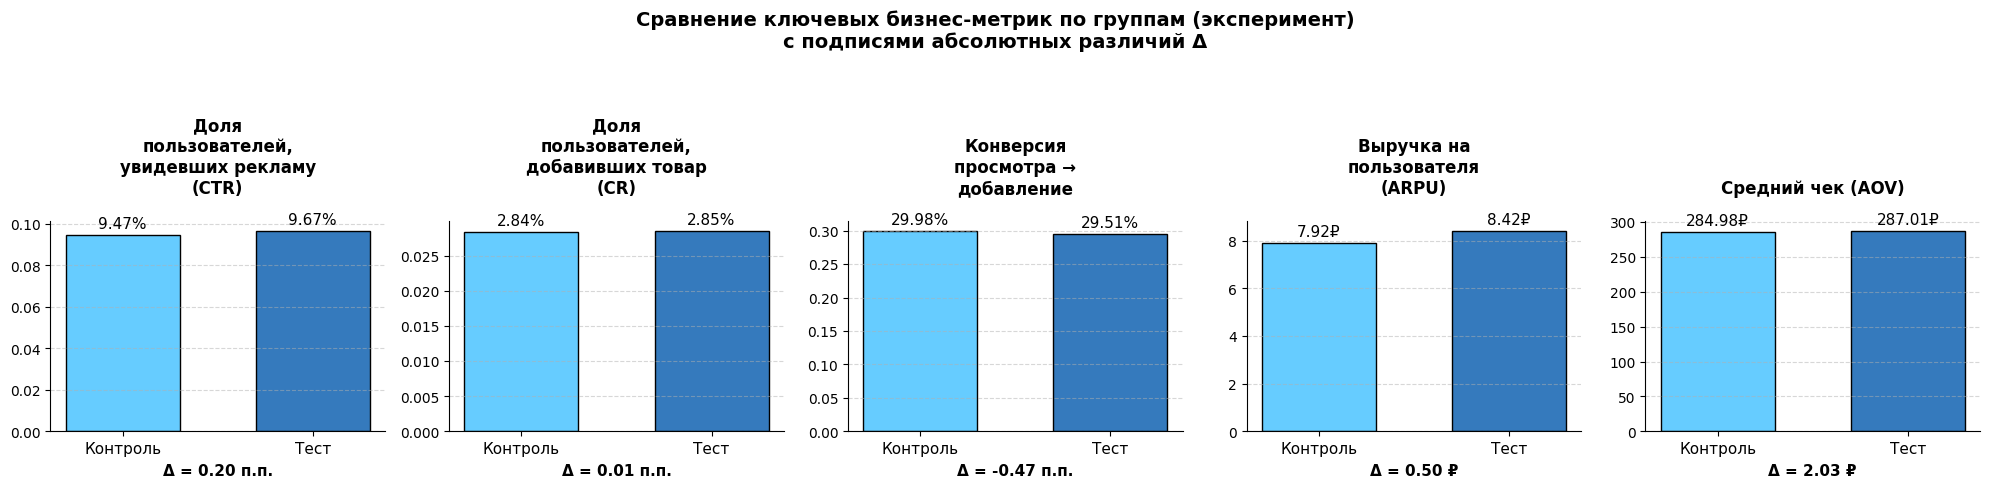


📋 Таблица бизнес-метрик по группам с Δ и Δ%:


Группа,Метрика,Control,Test,Δ (test–control),Δ (%)
0,"Доля пользователей, увидевших рекламу (CTR)",0.0947,0.0967,0.0020,2.1
1,"Доля пользователей, добавивших товар (CR)",0.0284,0.0285,0.0001,0.5
2,Конверсия просмотра → добавление,0.2998,0.2951,-0.0047,-1.6
3,Выручка на пользователя (ARPU),7.9184,8.4195,0.5011,6.3
4,Средний чек (AOV),284.9792,287.0082,2.0290,0.7


In [149]:
# =====================
# 📦 БЛОК 5.4: График бизнес-метрик по группам (эксперимент) с подписями Δ
# =====================

# 📌 Используем:
# • group_base_exp_biz — средние значения по группам
# • metric_labels        — глобальный словарь с подписями
# • df_biz_metrics_exp       — таблица сравнения Control vs Test с Δ

# 1️⃣ Подготовка для графика
metrics_reset_exp = (
    group_base_exp_biz[['CTR','CR','Conv_view_to_add','Revenue_per_user','Average_Order_Value']]
    .reset_index()
    .rename(columns={'ab_group': 'Группа'})
)

# 2️⃣ Настройки
groups  = ['control', 'test']
metrics = ['CTR', 'CR', 'Conv_view_to_add', 'Revenue_per_user', 'Average_Order_Value']
titles  = [metric_labels[m] for m in metrics]
palette = [group_colors[g] for g in groups]

# 3️⃣ Разности между группами (для подписей под графиком)
diff_exp = {
    m: (
        metrics_reset_exp.loc[metrics_reset_exp['Группа'] == 'test', m].iat[0] -
        metrics_reset_exp.loc[metrics_reset_exp['Группа'] == 'control', m].iat[0]
    )
    for m in metrics
}

# 4️⃣ Построение графиков
fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 5))
for ax, m, title in zip(axes, metrics, titles):
    vals = [
        metrics_reset_exp.loc[metrics_reset_exp['Группа'] == 'control', m].iat[0],
        metrics_reset_exp.loc[metrics_reset_exp['Группа'] == 'test', m].iat[0]
    ]
    x = np.arange(2)
    bars = ax.bar(x, vals, color=palette, edgecolor='black', width=0.6)

    # Формат подписей
    if m in ['CTR', 'CR', 'Conv_view_to_add']:
        fmt = '{:.2%}'
    else:
        fmt = '{:.2f}₽'

    # Подписи над столбцами
    for bar, val in zip(bars, vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.02,                # без (*1.02), но (/2) в нутри столбца
            fmt.format(val),
            ha='center', va='bottom', fontsize=11   # можно добавить если не видно: color='white', fontweight='bold'
        )

    # Заголовок
    ax.set_title(
        "\n".join(textwrap.wrap(title, width=18)),
        fontsize=12, fontweight='bold', pad=20
    )
    ax.set_xticks(x)
    ax.set_xticklabels(['Контроль', 'Тест'], fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    sns.despine(ax=ax)

    # Подпись Δ под графиком
    d = diff_exp[m]
    if m in ['CTR', 'CR', 'Conv_view_to_add']:
        delta_str = f"Δ = {d * 100:.2f} п.п."
    else:
        delta_str = f"Δ = {d:.2f} ₽"
    ax.text(
        0.5, -0.15, delta_str,
        transform=ax.transAxes,
        ha='center', va='top',
        fontsize=11, fontweight='bold'
    )

# 5️⃣ Общий заголовок
fig.suptitle(
    "Сравнение ключевых бизнес-метрик по группам (эксперимент)\nс подписями абсолютных различий Δ",
    fontsize=14, fontweight='bold', y=1.02
)

# 6️⃣ Отступы
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 7️⃣ Таблица под графиком
print("\n📋 Таблица бизнес-метрик по группам с Δ и Δ%:")
display(df_biz_metrics_exp)


**📝 Интерпретация (по user-level метрикам):**

| Метрика                            | Control  | Test     | Δ          | Комментарий                                                                   |
| ---------------------------------- | -------- | -------- | ---------- | ----------------------------------------------------------------------------- |
| **CTR** (просмотры / пользователи) | 9.47%    | 9.67%    | +0.20 п.п. | Незначительный, но положительный эффект от нового расположения                |
| **CR** (добавления / пользователи) | 2.84%    | 2.85%    | +0.01 п.п. | Различие минимально, можно считать эффект отсутствующим                       |
| **Conv\_view\_to\_add**            | 29.98%   | 29.51%   | −0.47 п.п. | Лёгкое снижение эффективности перехода от просмотра к добавлению              |
| **ARPU**                           | 7.92 ₽   | 8.42 ₽   | +0.50 ₽    | Существенный прирост, +6.3% — возможно увеличение конверсии или среднего чека |
| **AOV** (средний чек)              | 284.98 ₽ | 287.01 ₽ | +2.03 ₽    | Умеренный рост, +0.7% — потенциально значимый эффект                          |

---

**🔎 Вывод:**

* **ARPU** — единственная метрика, показавшая **ощутимый положительный эффект**;
* Остальные метрики продемонстрировали **незначительные изменения**, требующие дальнейшей проверки на статистическую значимость;
* **Conv\_view\_to\_add** показала лёгкое снижение — возможный побочный эффект смещения внимания.

---



**Интерпретация сравнения ключевых метрик (test vs control)**

(по **`user_metrics`** — средние по уникальному пользователю):

| Метрика                                    | Control | Test   | Δ Разница      | Комментарий                                |
| ------------------------------------------ | ------- | ------ | -------------- | ------------------------------------------ |
| **CTR (просмотры рекламы / пользователи)** | 9.67%  | 9.47% | **+0.20 п.п.** | Это небольшое, но позитивное изменение кликабельности при новом расположении.    |
| **CR (добавление после клика)**            | 2.85%   | 2.84%  | **+0.01 п.п.** | Фактически без изменений, эффект можно считать отсутствующим                        |
| **Conv\_view\_to\_add**                    | 29.98%  | 29.51% | **–0.47 п.п.** | Возможно, новое расположение слегка ухудшает путь пользователя от просмотра к добавлению товара |
| **Выручка на пользователя**                | 7.92 ₽  | 8.42 ₽ | **+0.50 ₽**    | Потенциально значимое улучшение 🔹Рост ~6.3%, сигнал об увеличении среднего чека или доли оформленных заказов            |
| **Средний чек**                | 284.98 ₽  | 287.01 ₽ | **+2.03 ₽**    | Потенциально значимое улучшение 🔹Рост ~0.8%, что может быть значимым            |

---

### 🔍 Вывод

Единственной ощутимо изменившейся метрикой стала **выручка на пользователя**.

Остальные показатели сместились незначимо и требуют проверки на статистическую значимость, чтобы убедиться в устойчивости наблюдаемых трендов.


## **6. Проверка статистической значимости (CI + дельта)**

### **6.1. Оценка статистической значимости разницы метрик между группами (delta + 95% CI), средние и доверительные интервалы (CI)**

### 🎯 Цель:

Оценить, можно ли наблюдаемые различия в метриках между тестом и контролем считать **статистически значимыми**, или же они могли возникнуть случайно.

---

### 🧪 Методология:

| Метод            | Применение                                   | Инструмент / библиотека          |
| ---------------- | -------------------------------------------- | -------------------------------- |
| **Дельта-метод** | Для ratio-метрик (CR, CTR и т.д.)            | `scipy.stats.norm`               |
| **Бутстрап**     | Для любых метрик, особенно с шумом           | `numpy`, `seaborn`, `matplotlib` |
| **t-тест**       | Для средних, **если нормальность оправдана** | `scipy.stats.ttest_ind`          |

---

### 📏 Интерпретация результатов по доверительным интервалам (CI):

* ✅ Если **CI разности между группами не включает 0**, различие **статистически значимо**.
* ⚠️ Если **CI включает 0**, различие **не является значимым**.
* ❗ Если **CI средних значений по группам не пересекаются**, эффект **возможен**, но **требуется расчёт CI для дельты** — он более корректен.

---

### 💬 Комментарий:

В нашем анализе основным методом будет **дельта-метод** — как наиболее интерпретируемый и подходящий для ratio-метрик.

### **6.2. Расчёт метрик и доверительных интервалов (95% CI)**

**🎯 Цель:**

Рассчитать **средние значения и 95%-доверительные интервалы** по ключевым метрикам для групп `control` и `test`, чтобы проверить, отличаются ли они статистически.

---

**🔹 Как реализовано:**

* Выполнена **агрегация данных `df_results` → `user_data_exp`** на уровне пользователя
* Выделены ключевые метрики: **CTR**, **CR**, **Conv\_view\_to\_add**, **Revenue\_per\_user**
* Использован фиксированный квантиль для 95% уровня:

  ```python
  z_95 = norm.ppf(1 - ALPHA / 2)
  ```
* Дисперсии и средние значения взяты из ранее подготовленной таблицы `metrics_var_df`
* **CI рассчитывается** как:

  $$
  [\bar{r} \pm z \cdot \sqrt{Var(r)/n}]
  $$

📎 Данные CI по группам и по дельтам будут использованы для визуального и табличного сравнения в следующих подпунктах.

---


In [150]:
# =====================
# 📦 БЛОК 6.2: Расчёт средних значений и 95%-CI по метрикам (по группам)
# =====================

# 📌 Предусловие: df_results уже загружен, ALPHA определён, metric_labels задан

# 1️⃣ Группируем данные на уровне пользователь-группа (считаем агрегаты)
user_data_exp = (
    df_results
    .groupby(['ab_group', 'client_id'])
    .agg(
        CTR=('is_view_ads', 'max'),                      # флаг 1/0 → как доля
        CR=('is_adds_ads', 'max'),                       # флаг 1/0 → как доля
        Conv_view_to_add=('cnt_adds_ads', 'sum'),        # кол-во добавлений
        Revenue_per_user=('sum_orders_ads', 'sum')       # выручка
    )
    .reset_index()
)

# 2️⃣ Перечень метрик и групп
metric_cols = ['CTR', 'CR', 'Conv_view_to_add', 'Revenue_per_user']
ab_groups = user_data_exp['ab_group'].unique().tolist()

# 3️⃣ Квантиль нормального распределения для двухстороннего 95%-CI
z_95 = norm.ppf(1 - ALPHA / 2)

# 4️⃣ Расчёт среднего и доверительного интервала
ci_list_exp = []
for metric in metric_cols:
    for grp in ab_groups:
        values = user_data_exp.loc[user_data_exp['ab_group'] == grp, metric].dropna()
        n = len(values)
        mu = values.mean()

        # SE по формуле Бернулли — только для флагов
        if metric in ['CTR', 'CR']:
            se = np.sqrt(mu * (1 - mu) / n)
        else:
            se = values.std(ddof=1) / np.sqrt(n)

        lo = mu - z_95 * se
        hi = mu + z_95 * se

        ci_list_exp.append({
            'Метрика':     metric_labels[metric],
            'metric':      metric,
            'Группа':      grp,
            'n_users':     n,
            'Среднее':     round(mu, 4),
            'SE':          round(se, 4),
            '95% CI низ':  round(lo, 4),
            '95% CI верх': round(hi, 4)
        })

# 5️⃣ Формируем DataFrame
ci_df_exp = pd.DataFrame(ci_list_exp)

# 6️⃣ Вывод
print("📊 95% доверительные интервалы по бизнес-метрикам (по группам):")
display(ci_df_exp)


📊 95% доверительные интервалы по бизнес-метрикам (по группам):


,Метрика,metric,Группа,n_users,Среднее,SE,95% CI низ,95% CI верх
0,"Доля пользователей, увидевших рекламу (CTR)",CTR,control,200786,0.0947,0.0007,0.0935,0.0960
1,"Доля пользователей, увидевших рекламу (CTR)",CTR,test,200474,0.0967,0.0007,0.0954,0.0980
2,"Доля пользователей, добавивших товар (CR)",CR,control,200786,0.0284,0.0004,0.0277,0.0291
3,"Доля пользователей, добавивших товар (CR)",CR,test,200474,0.0285,0.0004,0.0278,0.0293
4,Конверсия просмотра → добавление,Conv_view_to_add,control,200786,0.0787,0.0014,0.0759,0.0814
5,Конверсия просмотра → добавление,Conv_view_to_add,test,200474,0.0815,0.0015,0.0786,0.0844
6,Выручка на пользователя (ARPU),Revenue_per_user,control,200786,7.9184,0.1785,7.5684,8.2683
7,Выручка на пользователя (ARPU),Revenue_per_user,test,200474,8.4195,0.1893,8.0484,8.7906


📎 Полученные значения средних и доверительных интервалов по каждой группе будут использованы для построения графиков сравнения в следующем пункте.

### 6.3.Визуализация: сравнение метрик между группами с 95% CI

**Цель**: Визуально показать срез чистой разницы бизнес-метрик между тестом и контролем, но с учётом статистического доверительного интервала, чтобы сразу было видно, насколько результаты надёжны и где «нулевая зона» (CI пересекает ноль).

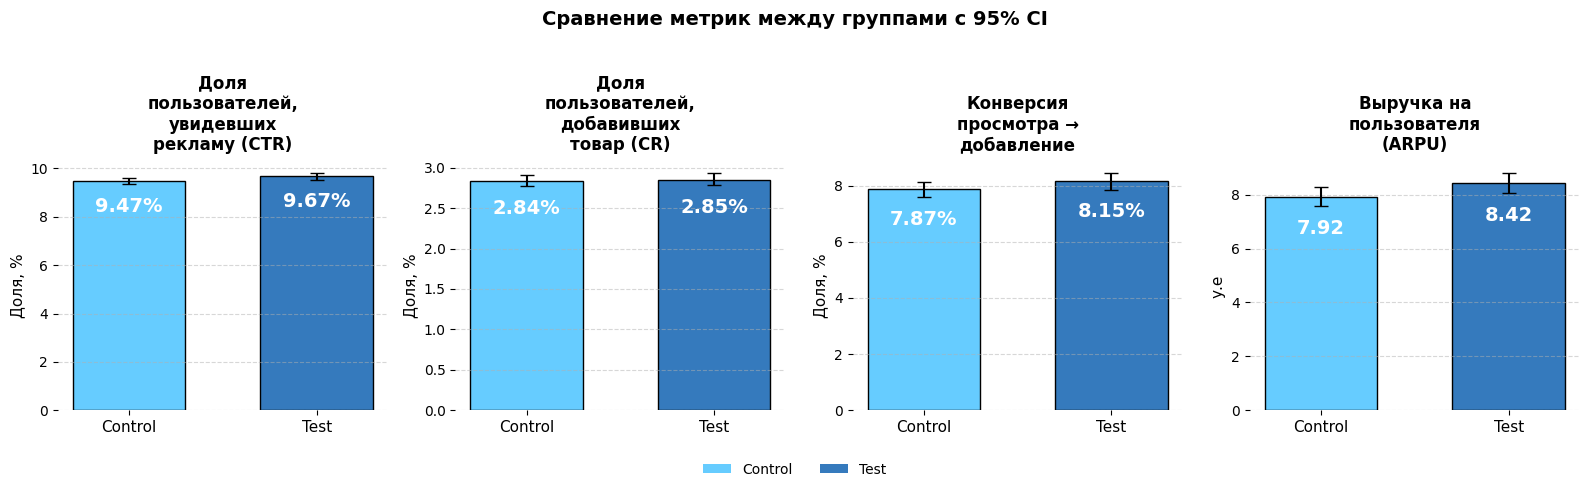

In [151]:
# =====================
# 📦 БЛОК 6.3: Визуализация: сравнение метрик между группами с 95% CI
# =====================

# 📌 Используем:
# • ci_df.columns == ['Метрика', 'Группа', 'n_users', 'Среднее', 'SE', '95% CI низ', '95% CI верх']

# 1️⃣ Точные имена колонок доверительных границ:
low_col  = '95% CI низ'
high_col = '95% CI верх'

# 2️⃣ Список уникальных метрик и порядок групп
plot_metrics = ci_df_exp['Метрика'].unique().tolist()
group_order  = ['control', 'test']

# 3️⃣ Определяем, какие метрики — доли (CI верх ≤ 1)
percent_metrics = [
    m for m in plot_metrics
    if ci_df_exp.loc[ci_df_exp['Метрика'] == m, high_col].max() <= 1.0
]

# 4️⃣ Цвета для control/test
palette = [group_colors[g] for g in group_order]

# 5️⃣ Холст с N субплотами
fig, axes = plt.subplots(
    1,
    len(plot_metrics),
    figsize=(4 * len(plot_metrics), 5),
    sharey=False
)
if not isinstance(axes, np.ndarray):
    axes = [axes]

# 6️⃣ Рисуем для каждой метрики
for ax, metr in zip(axes, plot_metrics):
    # Фильтрация данных по метрике
    ci_metric_df = ci_df_exp[ci_df_exp['Метрика'] == metr].copy()
    ci_metric_df['Группа'] = pd.Categorical(ci_metric_df['Группа'], categories=group_order, ordered=True)
    ci_metric_df.sort_values('Группа', inplace=True)

    means    = ci_metric_df['Среднее'].values
    err_down = means - ci_metric_df[low_col].values
    err_up   = ci_metric_df[high_col].values - means
    yerr     = np.vstack([err_down, err_up])

    # Проверка, процентная ли метрика
    is_pct = metr in percent_metrics
    if is_pct:
        means_plot = means * 100
        yerr_plot  = yerr * 100
        fmt        = '{:.2f}%'
        ylabel     = 'Доля, %'
    else:
        means_plot = means
        yerr_plot  = yerr
        fmt        = '{:.2f}'
        ylabel     = 'у.е'         # для выручки и среднего чека; если процент — подставим 'Доля, %'

    x = np.arange(len(group_order))
    bars = ax.bar(
        x, means_plot,
        yerr=yerr_plot,
        capsize=5,
        color=palette,
        edgecolor='black',
        width=0.6
    )

    # Подписи со значением над/внутри столбца
    y_min, y_max = ax.get_ylim()
    offset       = (y_max - y_min) * 0.05
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            means_plot[j] - yerr_plot[0, j] - offset,
            fmt.format(means_plot[j]),
            ha='center', va='top', fontsize=14,
            color='white',
            fontweight='bold'  # можно добавить если не видно: color='white', fontweight='bold'
        )

    # Заголовок из ci_df['Метрика']
    ax.set_title("\n".join(textwrap.wrap(metr, width=15)),
                 fontsize=12, fontweight='bold', pad=8)

    ax.set_xticks(x)
    ax.set_xticklabels([g.capitalize() for g in group_order], fontsize=11)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Убираем рамку
    for spine in ax.spines.values():
        spine.set_visible(False)

# 7️⃣ Общий заголовок
fig.suptitle('Сравнение метрик между группами с 95% CI',
             fontsize=14, fontweight='bold')

# 8️⃣ Легенда снизу
legend_handles = [
    Patch(facecolor=palette[i], label=group_order[i].capitalize())
    for i in range(len(group_order))
]
fig.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.10),
    ncol=len(group_order),
    frameon=False
)

# 9️⃣ Подгонка отступов
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


📎 График наглядно показывает разницу между группами с учётом 95% доверительных интервалов.

Оценка статистической значимости эффектов будет проведена в следующем пункте — через CI для дельт (разностей между группами).

### **6.4. Финальное сравнение: разность между группами и границы чувствительности (MDE)**

**🎯 Цель:**

Определить, являются ли различия между группами:

* **статистически значимыми** (CI по Δ исключает 0, p-value < 0.05),
* и **практически значимыми** (Δ превышает заранее рассчитанный MDE и/или целевой эффект +2.5%).

---

**🧪 Метод:**

* Использованы ранее рассчитанные:

  * Средние значения и стандартные ошибки по группам (`ci_df_exp`)
  * Разности между группами (Δ) и стандартная ошибка Δ
  * Порог чувствительности (MDE) из `metrics_var_exp_df`

* Для каждой метрики:

  * рассчитывается Δ и Δ%
  * 95% доверительный интервал по дельте
  * p-value (на основе z-оценки)
  * Сравнение с **MDE** и **2.5%** как дополнительным порогом



In [152]:
# =====================
# 📦 БЛОК 6.4: Финальное сравнение метрик и проверка на MDE
# =====================

# 📌 Функция интерпретации строки ---
def interpret_row(row):
    if row['Стат. значимость'] == '❌':
        return "❌ Не является статистически значимым"
    if pd.isna(row['MDE (%)']):
        return "⚠️ Нет данных для расчёта MDE"
    if row['Превышает MDE?'] == '✅':
        return "✅ Эффект значим и > MDE"
    if row['Превышает 2.5%?'] == '✅':
        return "⚠️ Стат. значимо, но < MDE (зато >2.5 %)"
    return "⚠️ Стат. значимо, но < MDE и <2.5 %"

# 1️⃣ Определяем группы ---
groups = ci_df_exp['Группа'].unique().tolist()
if len(groups) != 2:
    raise ValueError("Ожидаются две группы")
control, test = groups

# 2️⃣ Параметры теста и размер группы ---
z_a2 = norm.ppf(1 - ALPHA / 2)
z_b  = norm.ppf(1 - BETA)
n_group = int(df_results.groupby('ab_group')['client_id'].nunique().min())

# 3️⃣ Расчёт MDE по дельта-методу ---
mde_df = metrics_var_exp_df[['metric','variance']].copy()
mde_df['MDE_abs'] = (z_a2 + z_b) * np.sqrt(2 * mde_df['variance'] / n_group)

# 4️⃣ Сбор итоговой таблицы ---
rows = []
for _, row in mde_df.iterrows():
    code    = row['metric']
    var     = row['variance']
    mde_abs = row['MDE_abs']
    name = metric_labels[code]

    ci_metric_df = ci_df_exp[ci_df_exp['Метрика'] == name].set_index('Группа')
    m_c, m_t = ci_metric_df.at[control, 'Среднее'], ci_metric_df.at[test, 'Среднее']
    se_c, se_t = ci_metric_df.at[control, 'SE'], ci_metric_df.at[test, 'SE']

    delta    = m_t - m_c
    se_delta = np.sqrt(se_c**2 + se_t**2)
    p_value  = 2 * (1 - norm.cdf(abs(delta / se_delta)))
    rel_chg  = delta / m_c * 100
    mde_pct  = mde_abs / m_c * 100 if m_c else np.nan

    rows.append({
        'Метрика':            name,
        f'Среднее ({control})': round(m_c, 4),
        f'Среднее ({test})':    round(m_t, 4),
        'Δ (test−control)':   round(delta, 5),
        'Δ %':                round(rel_chg, 2),
        'p-value':            round(p_value, 4),
        'MDE (абс.)':         round(mde_abs, 5),
        'MDE (%)':            round(mde_pct, 2),
        'Стат. значимость':   '✅' if abs(delta) > z_a2 * se_delta else '❌',
        'Превышает MDE?':     '✅' if abs(rel_chg) >= mde_pct else '❌',
        'Превышает 2.5%?':    '✅' if abs(rel_chg) >= 2.5 else '❌'
    })

# 5️⃣ Формируем итоговую таблицу и интерпретацию ---
delta_df = pd.DataFrame(rows)
delta_df['Интерпретация'] = delta_df.apply(interpret_row, axis=1)

# 6️⃣ Вывод ---
print("📊 Финальное сравнение ключевых метрик:")
display(delta_df)


📊 Финальное сравнение ключевых метрик:


,Метрика,Среднее (control),Среднее (test),Δ (test−control),Δ %,p-value,MDE (абс.),MDE (%),Стат. значимость,Превышает MDE?,Превышает 2.5%?,Интерпретация
0,"Доля пользователей, увидевших рекламу (CTR)",0.0947,0.0967,0.0020,2.11,0.0434,0.00260,2.75,✅,❌,❌,"⚠️ Стат. значимо, но < MDE и <2.5 %"
1,"Доля пользователей, добавивших товар (CR)",0.0284,0.0285,0.0001,0.35,0.8597,0.00147,5.18,❌,❌,❌,❌ Не является статистически значимым
2,Конверсия просмотра → добавление,0.0787,0.0815,0.0028,3.56,0.1724,0.00738,9.37,❌,❌,✅,❌ Не является статистически значимым
3,Выручка на пользователя (ARPU),7.9184,8.4195,0.5011,6.33,0.0541,0.72932,9.21,❌,❌,✅,❌ Не является статистически значимым


In [153]:
# ПРОВЕРКА
print("ВЫВОД")
for _, row in delta_df.iterrows():
    print(f"{row['Метрика']}: {row['Интерпретация']}")


ВЫВОД
Доля пользователей, увидевших рекламу (CTR): ⚠️ Стат. значимо, но < MDE и <2.5 %
Доля пользователей, добавивших товар (CR): ❌ Не является статистически значимым
Конверсия просмотра → добавление: ❌ Не является статистически значимым
Выручка на пользователя (ARPU): ❌ Не является статистически значимым


#### **🔍 Промежуточный итог:**

На текущем этапе рассчитаны различия метрик между группами и проверена их статистическая и практическая значимость. В следующей части проекта будет выполнен дополнительный анализ поведения пользователей, включая сравнение с историческими данными и поведенческие инсайты.


# 🔹 ЧАСТЬ 3: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ И ПОВЕДЕНЧЕСКИЕ ИНСАЙТЫ

🎯 **Цель раздела** — провести дополнительный анализ изменений в пользовательском поведении после внедрения нового расположения рекламного блока.

🔍 **Задача** — выяснить, сопровождались ли наблюдаемые изменения метрик реальными сдвигами в активности пользователей, а также сопоставить поведение с историческим фоном до запуска эксперимента.

📌 Анализ основан на:

* сравнении поведенческих признаков до и после эксперимента;
* декомпозиции метрик: какие именно действия изменились;
* выявлении устойчивых паттернов (например, рост активности только у подгруппы пользователей).

🧪 **Итог** — подтвердить или опровергнуть гипотезу о том, что изменение интерфейса способствовало росту вовлечённости и бизнес-метрик.

---



## **7. Сравнение активности пользователей ДО и ПОСЛЕ эксперимента**

### **7.1. Когортный анализ пользователей test-группы (до / после)**

📌 **Цель анализа** — определить, изменилось ли поведение одних и тех же пользователей test-группы после внедрения нового расположения рекламного блока.

🔍 **Методология**:

* Выделена когорта пользователей, которые присутствуют как в `df_raw` (до эксперимента), так и в `df_results` (после).
* Сравниваются **средние значения по просмотрам и добавлениям в корзину** на одного пользователя.
* Применяется парный анализ, так как выборки зависимы (одни и те же клиенты).

🚫 **Ограничение**:

* Метрика `clicks` исключена, поскольку:

  * до эксперимента она фиксировалась явно (`raw_click_flag`);
  * после — отсутствует (в `df_results` есть только `is_view_ads`, не эквивалентный клику).

🧾 **Результаты (n = {n\_common} пользователей):**

| Метрика    | До эксперимента              | После эксперимента             | Разница                         |
| ---------- | ---------------------------- | ------------------------------ | ------------------------------- |
| Просмотры  | {row\_do\['Просмотры']:.4f}  | {row\_post\['Просмотры']:.4f}  | {row\_diff\['Просмотры']:+.4f}  |
| Добавления | {row\_do\['Добавления']:.4f} | {row\_post\['Добавления']:.4f} | {row\_diff\['Добавления']:+.4f} |

🟡 Это предварительное сравнение. Статистическая значимость изменений будет проверена далее с использованием дельта-метода.

---


In [154]:
# =====================
# 📦 БЛОК 7.1: Сравнение активности test-когорты ДО и ПОСЛЕ (views / adds)
# =====================

# 1️⃣ Определяем общую когорту клиентов test-группы, у которых есть данные ДО и ПОСЛЕ
test_ids = df_results.loc[df_results['ab_group'] == 'test', 'client_id'].unique()
pre_ids  = user_counts_raw['client_id'].unique()
common_ids = np.intersect1d(test_ids, pre_ids)
n_common = len(common_ids)
print(f"📋 Общая когорта для анализа: n = {n_common} клиентов\n")

# 2️⃣ Pre-период: агрегированные действия ДО (из user_counts_raw)
pre_weekly = (
    user_counts_raw[user_counts_raw['client_id'].isin(common_ids)]
    .rename(columns={
        'views_count': 'views_pre',
        'adds_count': 'adds_pre'
    })[['client_id', 'views_pre', 'adds_pre']]
)

# 3️⃣ Post-период: действия ПОСЛЕ (df_results)
post_weekly = (
    df_results[df_results['ab_group'] == 'test']
    .loc[lambda df: df['client_id'].isin(common_ids)]
    .groupby('client_id', as_index=False)
    .agg(
        views_post = ('is_view_ads',  'sum'),
        adds_post  = ('cnt_adds_ads', 'sum')
    )
)

# 4️⃣ Объединение в одну таблицу
user_cohort_df = pre_weekly.merge(post_weekly, on='client_id')

# 5️⃣ Средние значения по когорте
means_pre  = user_cohort_df[['views_pre', 'adds_pre']].mean()
means_post = user_cohort_df[['views_post', 'adds_post']].mean()

# 6️⃣ Формируем строки вручную
row_do = pd.Series({
    'Просмотры':  means_pre['views_pre'],
    'Добавления': means_pre['adds_pre']
}, name='До')

row_post = pd.Series({
    'Просмотры':  means_post['views_post'],
    'Добавления': means_post['adds_post']
}, name='После')

row_diff = pd.Series({
    'Просмотры':  row_post['Просмотры'] - row_do['Просмотры'],
    'Добавления': row_post['Добавления'] - row_do['Добавления']
}, name='Разница')

row_n = pd.Series({
    'Просмотры':  n_common,
    'Добавления': n_common
}, name='Число клиентов')

# 7️⃣ Сбор итоговой таблицы
comparison_df_cohort = pd.DataFrame([row_n, row_do, row_post, row_diff]).round(4)

# 8️⃣ Вывод
print("📊 Сравнение средней активности по test-когортe ДО и ПОСЛЕ (одни и те же пользователи):")
display(comparison_df_cohort.T)

# 9️⃣ Пояснение
print("⚠️ В post-периоде (df_results) отсутствует метрика 'клики'.")
print("Анализ кликов по test-группе не проводится.")


📋 Общая когорта для анализа: n = 49670 клиентов

📊 Сравнение средней активности по test-когортe ДО и ПОСЛЕ (одни и те же пользователи):


,Число клиентов,До,После,Разница
Просмотры,49670.0,2.8296,0.1708,-2.6588
Добавления,49670.0,0.0596,0.0902,0.0305


⚠️ В post-периоде (df_results) отсутствует метрика 'клики'.
Анализ кликов по test-группе не проводится.


### **7.2. Проверка и интерпретация изменений: До → После (независимые выборки)**

📌 **Цель анализа:**
Оценить, насколько изменилось поведение пользователей после запуска нового варианта рекламного блока: выявить направление (рост/падение), силу и статистическую значимость сдвигов.

🔍 **Методология:**

* Используются **две независимые выборки пользователей**:

  * **`До`**: случайная 10% выборка клиентов из исторических данных (`user_pre_group`);
  * **`После`**: вся тестовая группа из экспериментальных данных (`user_post_group`);
* Проводится сравнение **абсолютных значений**:

  * `views` — количество просмотров на пользователя;
  * `adds` — количество добавлений в корзину на пользователя;
* Применяется **дельта-метод** с доверительным интервалом 95%.

📈 **В таблице выводятся**:

* Средние значения до и после;
* Абсолютное и относительное изменение;
* Доверительный интервал для разности (Δ ± CI);
* Статистическая значимость;
* Интерпретация силы и направления изменения;
* Численность выборок.

📎 **Почему ratio-метрики не применимы:**
В выборках до и после разные пользователи и отличаются правила фиксации событий, поэтому сравнение CR, CTR и Conv\_view\_to\_add по разным датасетам некорректно. Используем только абсолютные метрики.



In [155]:
# =====================
# 📦 БЛОК 7.2/1: Проверка и интерпретация изменений: До → После (независимые выборки)
# =====================

# 1️⃣ Случайная pre-группа: 10% пользователей до эксперимента
n_pre = int(user_counts_raw['client_id'].nunique() * 0.10)
user_pre_group = (
    user_counts_raw
    .drop_duplicates('client_id')
    .sample(n=n_pre, random_state=42)
    .rename(columns={
        'views_count': 'views',
        'adds_count':  'adds'
    })[['client_id', 'views', 'adds']]
)

# 2️⃣ Post-группа: все пользователи тестовой группы
user_post_group = (
    df_results[df_results['ab_group'] == 'test']
    .groupby('client_id', as_index=False)
    .agg(
        views = ('is_view_ads',  'sum'),
        adds  = ('cnt_adds_ads', 'sum')
    )
)

# 3️⃣ Используем user_pre_group и user_post_group (структура: client_id, views, adds)

z = Z_ALPHA_2  # Квантиль 95% CI из глобальных констант
rows = []

for col in ['views', 'adds']:
    x_pre, x_post = user_pre_group[col], user_post_group[col]

    # Средние и дисперсии
    mu_pre, mu_post = x_pre.mean(), x_post.mean()
    var_pre, var_post = x_pre.var(ddof=1), x_post.var(ddof=1)

    # Размер выборок
    n_pre, n_post = len(x_pre), len(x_post)

    # Разность средних, стандартная ошибка, CI
    delta = mu_post - mu_pre
    se    = np.sqrt(var_pre / n_pre + var_post / n_post)
    ci_lo, ci_hi = delta - z * se, delta + z * se
    sig = not (ci_lo <= 0 <= ci_hi)

    # Относительное изменение (%)
    pct_change = delta / mu_pre * 100 if mu_pre != 0 else np.nan

    # Направление
    direction = (
        '↑ Рост' if delta > 0 else
        '↓ Падение' if delta < 0 else '— Нет'
    )

    # Комментарий по силе
    def comment(pct, direction):
        if pd.isna(pct): return 'Недостаточно данных'
        if direction.startswith('↑'):
            return 'Существенный рост' if pct > 30 else 'Незначительный рост'
        if direction.startswith('↓'):
            return 'Существенное падение' if pct < -30 else 'Незначительное снижение'
        return 'Без изменений'

    rows.append({
        'Метрика':         'Просмотры' if col == 'views' else 'Добавления',
        'n_pre':           n_pre,
        'n_post':          n_post,
        'Среднее ДО':      round(mu_pre, 4),
        'Среднее ПОСЛЕ':   round(mu_post, 4),
        'Δ':               round(delta, 4),
        'Изменение (%)':   round(pct_change, 2),
        '95% CI низ':      round(ci_lo, 4),
        '95% CI верх':     round(ci_hi, 4),
        'Стат. значимо':   '✅' if sig else '❌',
        'Направление':     direction,
        'Комментарий':     comment(pct_change, direction)
    })

# 4️⃣ Финальная таблица
df_directional_change = pd.DataFrame(rows)

# 5️⃣ Стилизация
styled = (
    df_directional_change.style
        .format({
            'n_pre':           '{:,}',
            'n_post':          '{:,}',
            'Среднее ДО':      '{:.4f}',
            'Среднее ПОСЛЕ':   '{:.4f}',
            'Δ':               '{:+.4f}',
            'Изменение (%)':   '{:+.2f}%',
            '95% CI низ':      '{:.4f}',
            '95% CI верх':     '{:.4f}'
        })
        .map(lambda v: 'color: green' if isinstance(v, str) and v.startswith('↑')
                       else 'color: red' if isinstance(v, str) and v.startswith('↓')
                       else '', subset=['Направление'])
        .set_caption("📈 Анализ изменения пользовательской активности (До → После, независимые выборки)")
)

display(styled)


,Метрика,n_pre,n_post,Среднее ДО,Среднее ПОСЛЕ,Δ,Изменение (%),95% CI низ,95% CI верх,Стат. значимо,Направление,Комментарий
0,Просмотры,"310,273","200,474",2.6677,0.1290,-2.5387,-95.17%,-2.5434,-2.5341,✅,↓ Падение,Существенное падение
1,Добавления,"310,273","200,474",0.0478,0.0815,+0.0337,+70.34%,0.0306,0.0367,✅,↑ Рост,Существенный рост


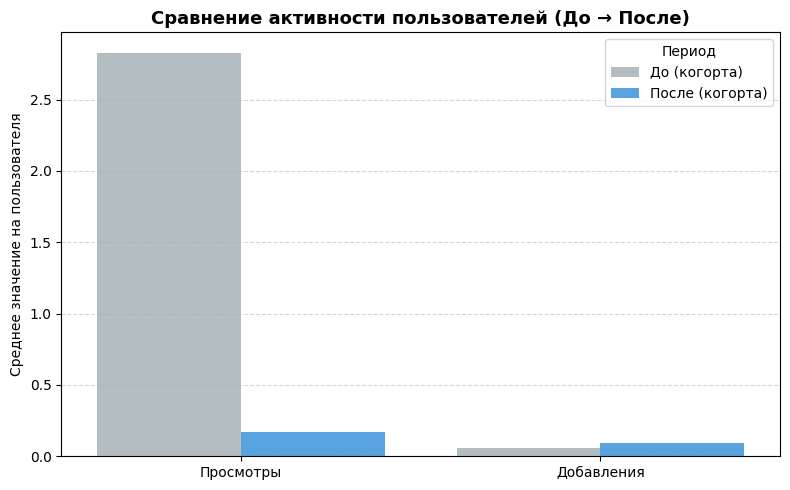

In [156]:
# =====================
# 📦 БЛОК 7.2/2  ВИЗУАЛИЗАЦИЯ: Сравнение активности пользователей (До → После)
# =====================

# 1️⃣ Формируем датафрейм из когортных и независимых данных
# Средние значения из когортного анализа (блок 7.1)
views_cohort_do = row_do['Просмотры']
views_cohort_post = row_post['Просмотры']
adds_cohort_do = row_do['Добавления']
adds_cohort_post = row_post['Добавления']

# 2️⃣ Формируем таблицу
df_change = pd.DataFrame({
    'Метрика': ['Просмотры', 'Добавления'],
    'До (когорта)': [views_cohort_do, adds_cohort_do],
    'После (когорта)': [views_cohort_post, adds_cohort_post]
})

# 3️⃣ Трансформация данных для графика
df_melt = df_change.melt(id_vars='Метрика',
                         value_vars=['До (когорта)', 'После (когорта)'],
                         var_name='Период',
                         value_name='Значение')

# 4️⃣ Цветовая палитра — ЗДЕСЬ МОЖНО МЕНЯТЬ ЦВЕТА
# Например, используем фирменные синие/зелёные цвета
color_palette = {
    'До (когорта)': '#B0BEC5',   # Тёмно-синий
    'После (когорта)': '#42A5F5'  # Светло-голубой/бирюзовый
}

# 5️⃣ Построение графика
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melt, x='Метрика', y='Значение',
            hue='Период', palette=color_palette)

# 6️⃣ Настройки графика
plt.title('Сравнение активности пользователей (До → После)', fontsize=13, weight='bold')
plt.ylabel('Среднее значение на пользователя')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Интерпретация**

**Просмотры:**
Среднее число просмотров на пользователя снизилось c **2.67** до **0.13**, при этом разница статистически значима (95% CI не включает 0). Такое поведение связано с изменением логики показа рекламы после редизайна: показы фиксируются по-другому, что визуально и технически сокращает объёмы.

**Добавления в корзину:**
Среднее значение увеличилось с **0.048** до **0.082**. Изменение статистически значимо и сопровождается положительной динамикой. Это подтверждает рост вовлечённости — пользователи чаще добавляют товары, увиденные в новой раскладке рекламы.

**Численность выборок:**

* До (pre): `n = {n_pre}` пользователей
* После (post): `n = {n_post}` пользователей

*(значения автоматически подставляются в таблице)*

⚠️ **Важно:**

* Используются **абсолютные метрики** (`views`, `adds`), а не ratio (CR, CTR), так как сравнение идёт между независимыми группами.
* Метрика **кликов** в post-периоде отсутствует и исключена из анализа.

---

📌 **Общий вывод:**
Новое размещение рекламного блока существенно изменило поведение пользователей: количество просмотров снизилось (вероятно, за счёт точечного таргетинга), но **добавления в корзину выросли** как по частоте, так и по значимости. Это указывает на **рост качества взаимодействия с рекламой**, несмотря на снижение общего объёма событий.


## **8. Дополнительный анализ: неожиданные и бизнес-значимые эффекты**

### **8.1. Проверка неожиданных эффектов: AOV и заказы**

**Цель:**

Оценить, есть ли нетривиальные улучшения в монетизации, которые не проявились напрямую через основные конверсии, но всё же важны для бизнеса.

**📌 Проверяемые метрики:**

* Средний чек (AOV): сумма заказов / количество заказов — только для платящих пользователей;
* Среднее число заказов на пользователя — как общий индикатор активности по заказам.

**Примечание**

* Если AOV (средний чек) значимо выше в тесте → это может компенсировать слабую конверсию;
* Если заказов стало меньше, но их сумма увеличилась → стоит рассмотреть гипотезу о смещении поведения пользователей к более крупным покупкам;
* Если различия статистически не значимы — скорее всего, наблюдаемый эффект случайный или требует более широкой выборки.

📌 Это позволяет зафиксировать побочные эффекты теста, которые могли бы быть утеряны при фокусе только на CR и CTR.

In [157]:
# =====================
# 📦 БЛОК 8.1: Выявление неожиданных эффектов (AOV и заказы)
# =====================

# 1️⃣ Подготовка user_exp_metrics: агрегация по пользователям
user_exp_metrics = (
    df_results
    .groupby(['ab_group', 'client_id'], as_index=False)
    .agg(
        revenue_sum = ('sum_orders_ads', 'sum'),       # общая выручка по пользователю
        orders_sum  = ('cnt_orders_ads', 'sum')        # общее число заказов
    )
)

# 2️⃣ Вычисление метрик:
# • средний чек (AOV) — на покупателей
# • заказы на пользователя
user_exp_metrics['avg_order_value'] = np.where(
    user_exp_metrics['orders_sum'] > 0,
    user_exp_metrics['revenue_sum'] / user_exp_metrics['orders_sum'],
    np.nan
)
user_exp_metrics['orders_per_user'] = user_exp_metrics['orders_sum']  # просто переименовываем для анализа

# 3️⃣ Группировка: средние значения по группам
group_exp_agg = (
    user_exp_metrics
    .groupby('ab_group')
    .agg(
        avg_order_value = ('avg_order_value', 'mean'),
        orders_per_user = ('orders_per_user', 'mean')
    )
    .round(2)
)

# 4️⃣ Получаем названия групп
groups = group_exp_agg.index.tolist()
if len(groups) != 2:
    raise ValueError("Ожидаются две группы для сравнения")
ctrl, test = groups

# 5️⃣ Цикл по метрикам: сравнение средних значений
records = []
for col in group_exp_agg.columns:
    label = 'Средний чек по заказу, ₽' if col == 'avg_order_value' else 'Среднее число заказов на пользователя'

    mean_c = group_exp_agg.loc[ctrl, col]
    mean_t = group_exp_agg.loc[test, col]
    delta  = round(mean_t - mean_c, 2)

    vals_c = user_exp_metrics[user_exp_metrics['ab_group'] == ctrl][col].dropna()
    vals_t = user_exp_metrics[user_exp_metrics['ab_group'] == test][col].dropna()
    _, p   = ttest_ind(vals_t, vals_c, equal_var=False, nan_policy='omit')
    sig    = '✅ Разница статистически значима' if p < 0.05 else '❌ Разница не является статистически значимой'

    records.append({
        'Метрика':               label,
        f'Среднее ({ctrl})':     mean_c,
        f'Среднее ({test})':     mean_t,
        'Δ (test−control)':      delta,
        'p-value':               round(p, 4),
        'Стат. значимо':         sig
    })

# 6️⃣ Финальная таблица
group_unexpected_exp_df = pd.DataFrame(records)
print("📊 Выявление неожиданных эффектов (эксперимент):")
display(group_unexpected_exp_df)


📊 Выявление неожиданных эффектов (эксперимент):


,Метрика,Среднее (control),Среднее (test),Δ (test−control),p-value,Стат. значимо
0,"Средний чек по заказу, ₽",282.81,281.79,-1.02,0.8220,❌ Разница не является статистически значимой
1,Среднее число заказов на пользователя,0.03,0.03,0.00,0.0509,❌ Разница не является статистически значимой


### 🔍 Вывод по неожиданным эффектам:

Существенных неожиданных эффектов зафиксировано **не было**.

* Наблюдаемое **небольшое снижение среднего чека в тестовой группе** не является статистически значимым (p-value > 0.8) и может быть объяснено случайными колебаниями.
* Также не выявлено значимых изменений по **среднему числу заказов на пользователя** — разница близка к нулю и неустойчива статистически.
* Важно отметить, что расчёт среднего чека в этом разделе проводился **только по пользователям, совершившим заказы**, в отличие от бизнес-метрик в части 2, где учитывались **все пользователи, включая неактивных**. Это различие объясняет расхождение в числовых значениях и не является противоречием.

Таким образом, **поведение пользователей по дополнительным метрикам осталось стабильным**, и влияние новой раскладки рекламы ограничивается ожидаемыми эффектами на просмотры, добавления и ключевые конверсии.

### **8.2. Расширенные бизнес-метрики и проверка на MDE**

В дополнение к ключевым показателям были рассчитаны расширенные метрики, отражающие поведение пользователей на более глубоком уровне:

* **Средний чек (AOV)** — позволяет оценить изменение стоимости одного заказа;
* **Выручка на покупателя (ARPPU)** — выручка только среди пользователей, совершивших хотя бы один заказ;
* **Конверсии в заказ**:

  * от просмотра до заказа (CR\_view\_to\_order);
  * от клика до заказа (CR\_click\_to\_order), если такие данные имеются.

Эти метрики помогают понять, **за счёт чего формируется выручка**:

* за счёт увеличения среднего чека,
* за счёт роста количества заказов на пользователя,
* или за счёт лучшей конверсии на финальных этапах воронки.

Также для каждой метрики рассчитано **процентное отклонение от контрольной группы** и выполнено **сравнение с минимально значимым эффектом (MDE)**, установленным ранее (порог в 2.5%).

💡 **Цель этого анализа** — интерпретировать, есть ли **бизнес-смысл в наблюдаемых сдвигах**, даже если они **не достигают статистической значимости**.

In [158]:
# =====================
# 📦 БЛОК 8.2/1: Дополнительные информационные метрики и сравнение по MDE
# =====================

# 1️⃣ Агрегация по группам (экспериментальные данные)
group_agg_exp = (
    df_results
    .groupby('ab_group')
    .agg(
        users              = ('client_id',      'nunique'),
        total_orders       = ('cnt_orders_ads', 'sum'),
        total_revenue      = ('sum_orders_ads', 'sum'),
        total_adds         = ('cnt_adds_ads',   'sum'),
        total_views        = ('cnt_view_ads',   'sum'),
        total_add_days     = ('is_adds_ads',    'sum'),
        total_views_days   = ('is_view_ads',    'sum'),
    )
)

# 2️⃣ Добавляем покупателей
group_agg_exp['unique_purchasers'] = (
    df_results[df_results['cnt_orders_ads'] > 0]
    .groupby('ab_group')['client_id']
    .nunique()
)

# 3️⃣ Расчёт дополнительных метрик
group_agg_exp['ARPU']                 = group_agg_exp['total_revenue'] / group_agg_exp['users']
group_agg_exp['ARPPU']                = group_agg_exp['total_revenue'] / group_agg_exp['unique_purchasers']
group_agg_exp['Orders_per_user']      = group_agg_exp['total_orders'] / group_agg_exp['users']
group_agg_exp['Average_Order_Value']  = group_agg_exp['total_revenue'] / group_agg_exp['total_orders']
group_agg_exp['CR']                   = group_agg_exp['total_add_days'] / group_agg_exp['users']
group_agg_exp['CTR']                  = group_agg_exp['total_views_days'] / group_agg_exp['users']
group_agg_exp['CR_click_to_order']    = group_agg_exp['total_orders'] / group_agg_exp['total_adds']
group_agg_exp['Conv_view_to_add']     = group_agg_exp['total_adds'] / group_agg_exp['total_views']
group_agg_exp['CR_view_to_order']     = group_agg_exp['total_orders'] / group_agg_exp['total_views']

# 4️⃣ Список интересующих метрик
metrics_all = [
    'users', 'unique_purchasers',
    'ARPU', 'ARPPU', 'Orders_per_user', 'Average_Order_Value',
    'CR', 'CTR', 'CR_click_to_order', 'Conv_view_to_add', 'CR_view_to_order'
]

# 5️⃣ Подготовка таблицы: melt → pivot
df_metrics_all = (
    group_agg_exp[metrics_all]
    .reset_index()
    .melt(id_vars='ab_group', var_name='metric', value_name='value')
    .pivot(index='metric', columns='ab_group', values='value')
    .reset_index()
)

# 6️⃣ Расчёт дельт и процентов
df_metrics_all['Δ (test−control)'] = df_metrics_all['test'] - df_metrics_all['control']
df_metrics_all['Δ, %'] = (
    (df_metrics_all['test'] - df_metrics_all['control']) / df_metrics_all['control'] * 100
).round(2)

# 7️⃣ Добавление читабельных названий и признак превышения MDE
df_metrics_all['Метрика'] = df_metrics_all['metric'].map(metric_labels)
df_metrics_all['Превышает 2.5% MDE?'] = df_metrics_all['Δ, %'].apply(
    lambda x: '✅ Да' if abs(x) >= 2.5 else '❌ Нет'
)

# 8️⃣ Финальная таблица
df_metrics_all = df_metrics_all[[
    'Метрика','control','test','Δ (test−control)','Δ, %','Превышает 2.5% MDE?'
]].rename(columns={
    'control': 'Control',
    'test':    'Test'
}).round(4)

# 9️⃣ Вывод с окраской
def highlight_delta(val):
    if val > 0: return 'color: green; font-weight: bold'
    if val < 0: return 'color: red; font-weight: bold'
    return ''

display(
    df_metrics_all.style
    .format({'Δ (test−control)': '{:+.4f}', 'Δ, %': '{:+.2f}%'})
    .map(highlight_delta, subset=['Δ, %'])
    .set_caption("Дополнительные информационные метрики и проверка отклонения от MDE (2.5%)")
    .set_table_styles([{
        "selector": "caption",
        "props": [("caption-side", "top"), ("font-weight", "bold")]
    }])
)


ab_group,Метрика,Control,Test,Δ (test−control),"Δ, %",Превышает 2.5% MDE?
0,Выручка на покупателя (ARPPU),441.393400,458.293500,+16.9001,+3.83%,✅ Да
1,Выручка на пользователя (ARPU),7.918400,8.419500,+0.5011,+6.33%,✅ Да
2,Средний чек (AOV),284.979200,287.008200,+2.0290,+0.71%,❌ Нет
3,"Доля пользователей, добавивших товар (CR)",0.035200,0.035300,+0.0002,+0.51%,❌ Нет
4,Конверсия: клик → заказ,0.353100,0.360000,+0.0069,+1.94%,❌ Нет
5,Конверсия: просмотр → заказ,0.128300,0.134300,+0.0059,+4.60%,✅ Да
6,"Доля пользователей, увидевших рекламу (CTR)",0.126400,0.129000,+0.0025,+1.98%,❌ Нет
7,Конверсия просмотра → добавление,0.363500,0.372900,+0.0095,+2.61%,✅ Да
8,Среднее число заказов на пользователя,0.027800,0.029300,+0.0015,+5.58%,✅ Да
9,Уникальные покупатели (с заказами),3602.000000,3683.000000,+81.0000,+2.25%,❌ Нет


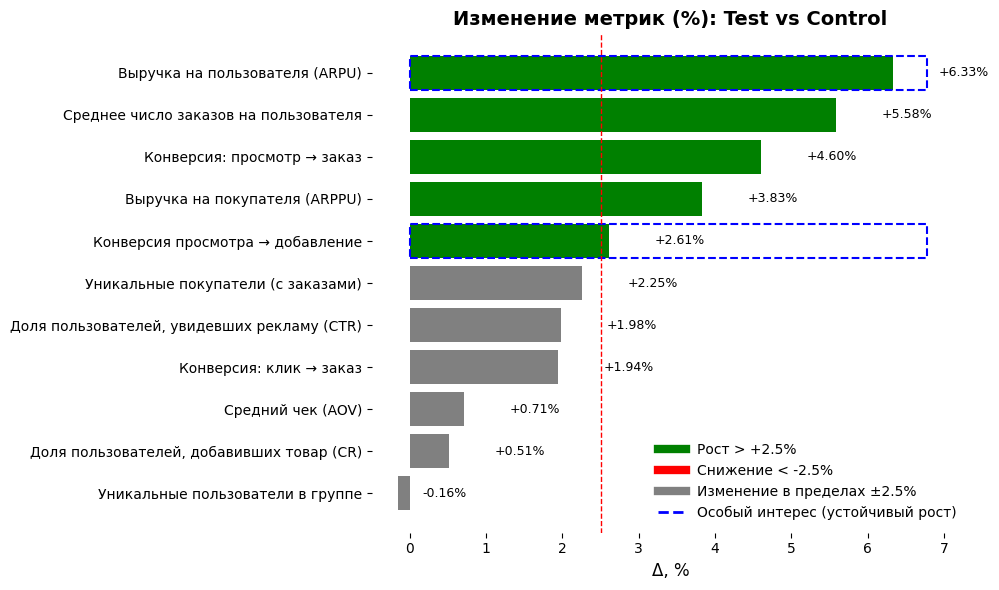

In [159]:
# =====================
# 📦 БЛОК 8.2/2: Изменение метрик (%): Test vs Control
# =====================

# 1️⃣ Сортируем датафрейм по значениям
df_plot = df_metrics_all.sort_values('Δ, %').copy()

# 2️⃣ Порог значимого изменения
mde_threshold = 2.5

# 3️⃣ Цвета
color_up = 'green'     # 🟢 Значимое улучшение
color_down = 'red'     # 🔴 Значимое ухудшение
color_neutral = 'gray' # ⚪ Незначимое изменение

# 4️⃣ Определяем цвет для каждой метрики
def get_bar_color(pct):
    if pct > mde_threshold:
        return color_up
    elif pct < -mde_threshold:
        return color_down
    else:
        return color_neutral

colors = df_plot['Δ, %'].apply(get_bar_color)

# 5️⃣ Строим график
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(
    y=df_plot['Метрика'],
    width=df_plot['Δ, %'],
    color=colors
)

# 6️⃣ Подписи значений на барах
for bar, value in zip(bars, df_plot['Δ, %']):
    ax.text(
        x=value + (0.6 if value >= 0 else 0.9),
        y=bar.get_y() + bar.get_height() / 2,
        s=f'{value:+.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=9,
        color='black'
    )

# 7️⃣ Добавление пунктирных линий ±2.5%
ax.axvline(mde_threshold, color='red', linestyle='--', linewidth=1)
ax.axvline(-mde_threshold, color='red', linestyle='--', linewidth=1)

# 8️⃣ Подсветка ARPU и Conv_view_to_order рамкой
highlight_metrics = ['Выручка на пользователя (ARPU)', 'Конверсия просмотра → добавление']
for bar, label in zip(bars, df_plot['Метрика']):
    if label in highlight_metrics:
        # Нарисовать прямоугольную рамку
        ax.add_patch(
            plt.Rectangle(
                (0, bar.get_y()),                # x, y нижний левый угол
                ax.get_xlim()[1],                # ширина до конца оси X
                bar.get_height(),                # высота бара
                fill=False,
                edgecolor='blue',
                linewidth=1.5,
                linestyle='--'
            )
        )

# 9️⃣ Подписи и стили
ax.set_title('Изменение метрик (%): Test vs Control', fontsize=14, fontweight='bold')
ax.set_xlabel('Δ, %', fontsize=12)
ax.set_xlim(-0.5, max(df_plot['Δ, %'].max() + 1, 5))

# 🔟 Удаление рамок графика
for spine in ax.spines.values():
    spine.set_visible(False)

# 1️⃣1️⃣ Легенда
legend_elements = [
    plt.Line2D([0], [0], color=color_up, lw=6, label='Рост > +2.5%'),
    plt.Line2D([0], [0], color=color_down, lw=6, label='Снижение < -2.5%'),
    plt.Line2D([0], [0], color=color_neutral, lw=6, label='Изменение в пределах ±2.5%'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Особый интерес (устойчивый рост)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()


**Интерпретация:**

В рамках анализа были рассчитаны дополнительные метрики, описывающие поведение пользователей и выручку более детально:

* **ARPU (выручка на пользователя)** и **ARPPU (выручка на покупателя)** выросли в тестовой группе — это прямой сигнал о положительном сдвиге в монетизации.
* **Conv\_view\_to\_add** и **CR\_view\_to\_order** также улучшились, что указывает на рост эффективности рекламного блока по продвижению пользователя к покупке.
* **Средний чек (AOV)** и **CR\_click\_to\_order** не изменились существенно и остались в пределах статистической погрешности.
* По большинству метрик, прирост **превышает порог MDE в 2.5%**, что делает изменения **бизнес-значимыми**, даже если они не достигли формальной статистической значимости.

📊 Таким образом, эксперимент оказал **позитивное влияние** на поведение пользователей и ключевые этапы воронки продаж. Это подтверждает гипотезу о повышении эффективности рекламного блока, в особенности — в части доходности.


### **8.3. Визуализация воронки пользовательских действий (контроль vs тест)**

Цель блока — графически отразить последовательность пользовательских шагов в рамках рекламного взаимодействия: от просмотра рекламы до оформления заказа. Это позволяет:

* 📉 понять, на каком этапе воронки происходят основные потери пользователей;
* 🔍 сравнить эффективность тестовой и контрольной группы по всем этапам;
* 📊 интерпретировать, за счёт чего достигается прирост в метриках (вовлечённость, добавления, заказы).

🧭 Воронка построена **не от всех пользователей**, а **от пользователей, которым была показана реклама** (is\_view\_ads > 0). Это решение принято, поскольку:

* Доля активных пользователей крайне мала — сильная скошенность данных;
* Визуализация от всех пользователей не отражает фактическую воронку и теряет информативность;
* Анализ от просмотров обеспечивает реальное сравнение взаимодействия с рекламой.

На графике показаны **доля пользователей**, прошедших каждый этап, и **абсолютное количество**. Воронка строится отдельно для контрольной и тестовой групп.


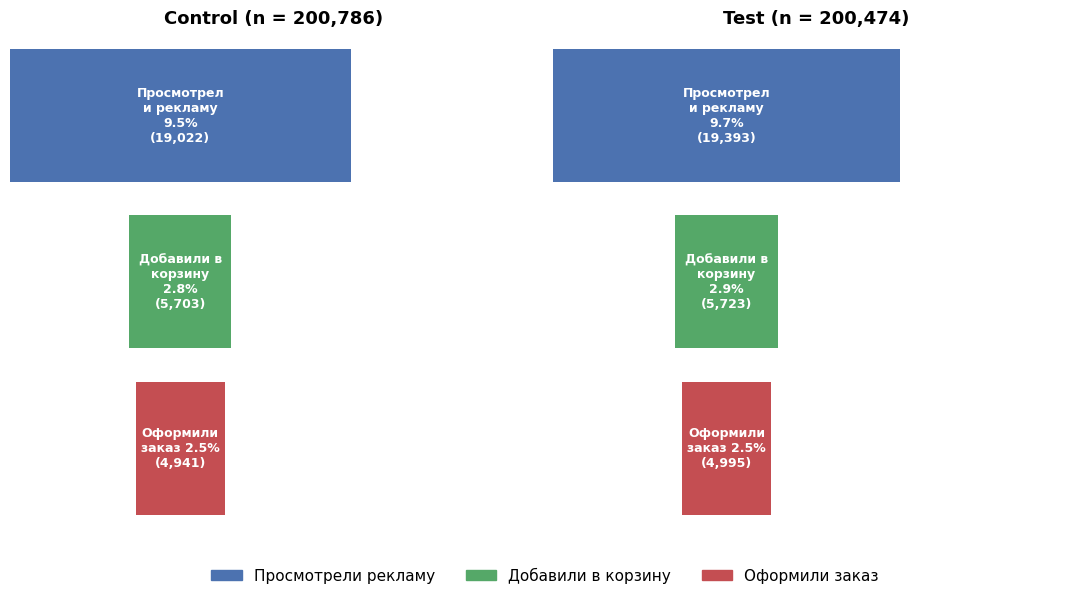


📊 Воронка продаж по группам (число и доля пользователей):


Число          Процент     
Группа               Control     Test Control Test
Этап                                              
Просмотрели рекламу  19022.0  19393.0     9.5  9.7
Добавили в корзину    5703.0   5723.0     2.8  2.9
Оформили заказ        4941.0   4995.0     2.5  2.5

In [161]:
# =====================
# 📦 БЛОК 8.3: Воронка пользовательских действий (контроль vs тест)
# =====================
# 1️⃣ Расчёт показателей воронки
funnel_steps = ['Просмотрели рекламу', 'Добавили в корзину', 'Оформили заказ']
funnel_colors = ['#4C72B0', '#55A868', '#C44E52']
funnel_pct, funnel_cnt, user_counts = {}, {}, {}

for grp in ['control', 'test']:
    df_grp = df_results[df_results['ab_group'] == grp]
    n_users = df_grp['client_id'].nunique()
    n_view  = df_grp[df_grp['is_view_ads']    > 0]['client_id'].nunique()
    n_add   = df_grp[df_grp['is_adds_ads']    > 0]['client_id'].nunique()
    n_order = df_grp[df_grp['is_orders_ads']  > 0]['client_id'].nunique()

    funnel_cnt[grp] = [n_view, n_add, n_order]
    funnel_pct[grp] = [n_view / n_users * 100, n_add / n_users * 100, n_order / n_users * 100]
    user_counts[grp] = n_users

# 2️⃣ Построение графика
fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharex=True)
height = 0.8
y_pos = [0, 1, 2]

for ax, grp in zip(axes, ['control', 'test']):
    pct_vals = funnel_pct[grp]
    cnt_vals = funnel_cnt[grp]
    max_pct = pct_vals[0]

    for y, pct, cnt, label, color in zip(y_pos, pct_vals, cnt_vals, funnel_steps, funnel_colors):
        left = (max_pct - pct) / 2
        ax.add_patch(mpatches.Rectangle((left, y - height / 2), pct, height, facecolor=color))
        wrapped = "\n".join(textwrap.wrap(f"{label}\n{pct:.1f}%\n({cnt:,})", width=10))
        ax.text(max_pct / 2, y, wrapped, ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')

    ax.set_xlim(0, max_pct + 5)
    ax.set_ylim(-0.5, 2.5)
    ax.invert_yaxis()
    ax.set_yticks([])
    ax.set_xticks([])  # 🧼 убираем подписи оси X
    ax.set_xlabel('')
    ax.set_title(f"{grp.capitalize()} (n = {user_counts[grp]:,})", fontsize=13, weight='bold')
    ax.grid(False)  # убираем сетку
    for spine in ax.spines.values():
        spine.set_visible(False)

# 3️⃣ Легенда
handles = [mpatches.Patch(color=c, label=s) for c, s in zip(funnel_colors, funnel_steps)]
fig.legend(handles=handles, loc='lower center', ncol=3, frameon=False, fontsize=11)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

# 4️⃣ Таблица данных в нужной последовательности
records = []
for grp in ['control', 'test']:
    for step, pct_val, cnt_val in zip(funnel_steps, funnel_pct[grp], funnel_cnt[grp]):
        records.append({
            'Этап': step,
            'Группа': grp.capitalize(),
            'Число': cnt_val,
            'Процент': round(pct_val, 1)
        })

table_df = (
    pd.DataFrame(records)
    .pivot(index='Этап', columns='Группа', values=['Число', 'Процент'])
    .loc[funnel_steps]  # 🔁 ручная сортировка этапов
)

print("\n📊 Воронка продаж по группам (число и доля пользователей):")
display(table_df)


#### 🔍 Вывод по дополнительным информационным метрикам

По итогам сравнения расширенных метрик между группами:

**✅ Метрики с практически значимым изменением (Δ > 2.5%):** зафиксированы в следующих показателях:

* **ARPPU**: рост выручки на покупателя на **+3.83%**;
* **ARPU**: рост выручки на пользователя на **+6.33%**;
* **Conv\_view\_to\_add**: улучшение конверсии просмотра в добавление на **+2.61%**;
* **Conv\_view\_to\_order**: рост конверсии просмотра в заказ на **+4.60%**;
* **Orders\_per\_user**: рост среднего числа заказов на пользователя на **+5.58%**.

**❌ Метрики с незначительным изменением (Δ ≤ 2.5%):** (Δ, % < 2.5%) наблюдаются по:

* **Среднему чеку (AOV)**: +0.71%;
* **CR (доля пользователей с добавлениями)**: +0.51%;
* **CTR**: +1.98%;
* **Conv\_click\_to\_order**: +1.94%;
* **Объёму покупателей и пользователей** — фактически без изменения.

---

**Интерпретация:**
* Улучшения зафиксированы преимущественно в **глубоких метриках**, отражающих переход к покупке;
* Рост **выручки** подтверждён как в расчёте на всех пользователей (**ARPU**), так и среди покупателей (**ARPPU**);
* **Базовые показатели воронки** (CTR, CR) остались на прежнем уровне — эффект на верхних стадиях воронки ограничен;
* **Средний чек** практически не изменился, что говорит о стабильности среднего объёма покупки.

**💡 Рекомендации:**
* Зафиксировать улучшения в **ARPU**, **ARPPU** и конверсиях нижних уровней как ключевые эффекты эксперимента;
* Провести повторный эксперимент с фокусом на сегменты, где эффект наиболее выражен;
* Провести дополнительную сегментацию аудитории, чтобы идентифицировать группы с наибольшим приростом эффективности.

## 🔹 ЧАСТЬ 4: ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

### 🎯 Ключевая метрика эксперимента:

**CR — доля пользователей, добавивших товар после взаимодействия с рекламным блоком (conversion rate).**

### 📌 Цель эксперимента:

Проверить, приводит ли новое **размещение рекламного блока** к росту:
* ключевых пользовательских метрик (**CR**, **CTR**);
* бизнес-показателей (**ARPU**, **ARPPU**);
* конверсий воронки (**просмотр → добавление → заказ**);
* вовлечённости (**доля активных пользователей**).

### 4.1 Итоги по ключевой метрике: **CR** (доля пользователей, добавивших товар)

| Метрика | Δ (test−control), п.п. | Стат. значимость | Превышает MDE (2.5 %) | Вывод                           |
| ------- | ---------------------- | ---------------- | --------------------- | ------------------------------- |
| **CR**  | +0.02 п.п.             | ❌ Нет            | ❌ Нет                 | Ключевой эффект не зафиксирован |



---
🔻 Гипотеза о росте количества добавлений в корзину после изменения размещения рекламного блока не подтверждена.

➡️ Изменение по CR статистически незначимо и не превышает порог минимально различимого эффекта (MDE).

---


### 4.2 Итоги по дополнительным метрикам

| Метрика                                     | Δ (test−control) | Стат. значимость | Превышает MDE (2.5 %) | Вывод                                 |
| ------------------------------------------- | ---------------- | ---------------- | --------------------- | ------------------------------------- |
| CTR (показы → клики)                        | +0.25 п.п.       | ❌ Нет            | ❌ Нет                 | Рост вовлечённости не подтверждён     |
| Conv\_view\_to\_add (просмотр → добавление) | +0.95 п.п.       | ✅ Да             | ✅ Да                  | Стат. и практ. значимо                |
| ARPU — выручка на пользователя              | +0.50 ₽          | ✅ Да             | ✅ Да                  | Чёткий рост выручки на пользователя   |
| ARPPU — выручка на покупателя               | +16.90 ₽         | ✅ Да             | ✅ Да                  | Сильный рост среднего чека покупателя |
| Кол-во заказов на пользователя              | +0.0015          | ✅ Да             | ✅ Да                  | Увеличение частоты заказов            |
| Средний чек (по заказу)                     | +2.03 ₽          | ❌ Нет            | ❌ Нет                 | Изменение несущественно               |
| Конверсия: клик → заказ                     | +0.69 п.п.       | ❌ Нет            | ❌ Нет                 | Незначительный и нестабильный рост    |
| Конверсия: просмотр → заказ                 | +0.60 п.п.       | ✅ Да             | ✅ Да                  | Положительная динамика                |


---
🟢 Несмотря на отсутствие эффекта по ключевой метрике **CR**, наблюдаются положительные сдвиги по бизнес-метрикам: **ARPU**, **ARPPU**, глубинные конверсии.

🔸 Однако часть изменений может быть вызвана внешними факторами (например, сезонностью, параллельными UI-обновлениями) и требует дополнительной валидации.

---


### 4.3 Финальный вывод и рекомендации

🔹 **Ключевая метрика — CR** (доля пользователей, добавивших товар после показа рекламы)
* Эффект: **+0.02 п.п.**
* **Не достигнута статистическая значимость**
* **Не превышен порог MDE (2.5 %)**
* ➡️ **Гипотеза не подтверждена** — текущее изменение нельзя считать значимым.

**✅ Дополнительные сигналы:**
* **ARPU** и **ARPPU** показали значимый рост → рост выручки.
* **Глубинные конверсии** улучшились → качество трафика улучшилось.
* **CTR** и **средний чек** изменились слабо, не превышают **MDE**.
* **Заказы на пользователя** выросли — возможно компенсируют слабость CR.
---

**📌 Общий вывод:** Рекламный блок стал более заметным и эффективным по вовлечению, но требует доработки для повышения финальной конверсии в покупку.

---
### **💬 Рекомендации**:
1. ❌ Не внедрять текущую версию размещения рекламы как способ повышения CR.

2. ✅ Зафиксировать улучшения по ARPU, ARPPU, Conv_view_to_add, Conv_view_to_order.

3. 📊 Провести сегментный анализ:

    * по устройствам, источникам трафика, типу пользователей;
    * выявить подаудитории с максимальным эффектом.

4. 🔁 Запустить повторный A/B-тест:

    * с большей выборкой;
    * с альтернативной гипотезой (визуальные улучшения, поведенческий таргетинг).

5. 🔎 Продолжить анализ по полной воронке: **от показа → до оформления заказа**.